# **Explainable Reinforcement Learning Tutorial**

Welcome to this tutorial on **Explainable Reinforcement Learning (XRL)**! In this guide, we'll explore how to interpret and explain the decisions made by reinforcement learning agents using the SHAP (SHapley Additive exPlanations) library. We'll work through a practical example involving an Assume simulation in a reinforcement learning setting, and demonstrate how to compute and visualize feature attributions for the agent's actions.

## **Table of Contents**

1. [Introduction](#introduction)
2. [Prerequisites](#prerequisites)
3. [Understanding the Dataset and Model](#understanding-the-dataset-and-model)
4. [Loading and Preparing Data](#loading-and-preparing-data)
5. [Exploring the Trained Actor Model](#exploring-the-trained-actor-model)
6. [Evaluating the Model](#evaluating-the-model)
7. [Explainable AI with SHAP](#explainable-ai-with-shap)
   - 7.1 [Creating a SHAP Explainer](#creating-a-shap-explainer)
   - 7.2 [Calculating SHAP Values](#calculating-shap-values)
   - 7.3 [Visualizing SHAP Values](#visualizing-shap-values)
8. [Interpreting the Results](#interpreting-the-results)
9. [Coding Tasks](#coding-tasks)
10. [Conclusion](#conclusion)
11. [Additional Resources](#additional-resources)

## **1. Introduction** <a name="introduction"></a>

Reinforcement Learning (RL) has achieved remarkable success in various domains, such as game playing, robotics, and autonomous systems. However, RL models, particularly those using deep neural networks, are often seen as black boxes due to their complex architectures and non-linear computations. This opacity poses challenges in understanding and trusting the decisions made by RL agents, especially in critical applications.

**Explainable Reinforcement Learning (XRL)** aims to bridge this gap by providing insights into the agent's decision-making process. By leveraging explainability techniques, we can interpret the actions of an RL agent, understand the influence of input features, and potentially improve the model's performance and fairness.

In this tutorial, we'll demonstrate how to apply SHAP values to a trained actor neural network within an RL framework to explain the agent's actions.

### 1.1 Multi-Agent Deep Reinforcement Learning

In ASSUME, we implement RL agents using a Multi-Agent Deep Reinforcement Learning (MADRL) approach. Key aspects include:


- **Observations**: Each agent receives observations comprising market forecasts, unit-specific information, and past actions.
- **Actions**: Agents decide on bidding strategies, such as bid prices for inflexible and flexible capacities.
- **Rewards**: Agents receive rewards based on profits and opportunity costs, guiding them to learn optimal bidding strategies.
- **Algorithm**: We utilize a multi-agent version of the TD3 algorithm, ensuring stable learning in a non-stationary environment.

For a deep dive into the RL configartions we refer to one of the other tutorials, such as 
[Deep Reinforcement Learning Tutorial](https://example.com/deep-rl-tutorial)

Agents need observations to make informed decisions. Observations include:

- **Residual Load Forecast**: Forecasted net demand over the next 24 hours.
- **Price Forecast**: Forecasted market prices over the next 24 hours.
- **Marginal Cost**: Current marginal cost of the unit.
- **Previous Output**: Dispatched capacity from the previous time step.


Agents choose actions based on the observations. The action space is two-dimensional, corresponding to:

- Bid Price for Inflexible Capacity (p_inflex): The price at which the agent offers its minimum power output (must-run capacity) to the market.
- Bid Price for Flexible Capacity (p_flex): The price for the additional capacity above the minimum output that the agent can flexibly adjust.


#### Run an Assume MADRL Simulation

Similar to teh other tutorial, we can run Assume in the following way. 

In [1]:
#!pip install 'assume-framework[learning]'
#!git clone https://github.com/assume-framework/assume.git assume-repo

In [2]:
import importlib.util

# Check if 'google.colab' is available
IN_COLAB = importlib.util.find_spec("google.colab") is not None

colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

For XRL, we need enhanced logging of the learning process, which is not currently a feature of ASSUME itself. Therefore, we are overriding some functions to enable this logging specifically for the purpose of this tutorial.

In [3]:
# @title Overwrite run_learning function with enhanced logging

import json
import logging
import os
from collections import defaultdict
from pathlib import Path

import numpy as np
import yaml
from tqdm import tqdm

from assume.common.exceptions import AssumeException
from assume.scenario.loader_csv import (
    load_config_and_create_forecaster,
    setup_world,
)
from assume.world import World

logger = logging.getLogger(__name__)


def run_learning(
    world: World,
    inputs_path: str,
    scenario: str,
    study_case: str,
    verbose: bool = False,
) -> None:
    """
    Train Deep Reinforcement Learning (DRL) agents to act in a simulated market environment.

    This function runs multiple episodes of simulation to train DRL agents, performs evaluation, and saves the best runs. It maintains the buffer and learned agents in memory to avoid resetting them with each new run.

    Args:
        world (World): An instance of the World class representing the simulation environment.
        inputs_path (str): The path to the folder containing input files necessary for the simulation.
        scenario (str): The name of the scenario for the simulation.
        study_case (str): The specific study case for the simulation.

    Note:
        - The function uses a ReplayBuffer to store experiences for training the DRL agents.
        - It iterates through training episodes, updating the agents and evaluating their performance at regular intervals.
        - Initial exploration is active at the beginning and is disabled after a certain number of episodes to improve the performance of DRL algorithms.
        - Upon completion of training, the function performs an evaluation run using the best policy learned during training.
        - The best policies are chosen based on the average reward obtained during the evaluation runs, and they are saved for future use.
    """
    from assume.reinforcement_learning.buffer import ReplayBuffer

    if not verbose:
        logger.setLevel(logging.WARNING)

    # remove csv path so that nothing is written while learning
    temp_csv_path = world.export_csv_path
    world.export_csv_path = ""

    # initialize policies already here to set the obs_dim and act_dim in the learning role
    actors_and_critics = None
    world.learning_role.initialize_policy(actors_and_critics=actors_and_critics)
    world.output_role.del_similar_runs()

    # check if we already stored policies for this simualtion
    save_path = world.learning_config["trained_policies_save_path"]

    if Path(save_path).is_dir():
        # we are in learning mode and about to train new policies, which might overwrite existing ones
        accept = input(
            f"{save_path=} exists - should we overwrite current learnings? (y/N) "
        )
        if not accept.lower().startswith("y"):
            # stop here - do not start learning or save anything
            raise AssumeException("don't overwrite existing strategies")

    # -----------------------------------------
    # Load scenario data to reuse across episodes
    scenario_data = load_config_and_create_forecaster(inputs_path, scenario, study_case)

    # -----------------------------------------
    # Information that needs to be stored across episodes, aka one simulation run
    inter_episodic_data = {
        "buffer": ReplayBuffer(
            buffer_size=int(world.learning_config.get("replay_buffer_size", 5e5)),
            obs_dim=world.learning_role.rl_algorithm.obs_dim,
            act_dim=world.learning_role.rl_algorithm.act_dim,
            n_rl_units=len(world.learning_role.rl_strats),
            device=world.learning_role.device,
            float_type=world.learning_role.float_type,
        ),
        "actors_and_critics": None,
        "max_eval": defaultdict(lambda: -1e9),
        "all_eval": defaultdict(list),
        "avg_all_eval": [],
        "episodes_done": 0,
        "eval_episodes_done": 0,
        "noise_scale": world.learning_config.get("noise_scale", 1.0),
    }

    # -----------------------------------------

    validation_interval = min(
        world.learning_role.training_episodes,
        world.learning_config.get("validation_episodes_interval", 5),
    )

    eval_episode = 1

    for episode in tqdm(
        range(1, world.learning_role.training_episodes + 1),
        desc="Training Episodes",
    ):
        # TODO normally, loading twice should not create issues, somehow a scheduling issue is raised currently
        if episode != 1:
            setup_world(
                world=world,
                scenario_data=scenario_data,
                study_case=study_case,
                episode=episode,
            )

        # -----------------------------------------
        # Give the newly initliazed learning role the needed information across episodes
        world.learning_role.load_inter_episodic_data(inter_episodic_data)

        world.run()

        # -----------------------------------------
        # Store updated information across episodes
        inter_episodic_data = world.learning_role.get_inter_episodic_data()
        inter_episodic_data["episodes_done"] = episode

        # evaluation run:
        if (
            episode % validation_interval == 0
            and episode
            >= world.learning_role.episodes_collecting_initial_experience
            + validation_interval
        ):
            world.reset()

            # load evaluation run
            setup_world(
                world=world,
                scenario_data=scenario_data,
                study_case=study_case,
                perform_evaluation=True,
                eval_episode=eval_episode,
            )

            world.learning_role.load_inter_episodic_data(inter_episodic_data)

            world.run()

            total_rewards = world.output_role.get_sum_reward()
            avg_reward = np.mean(total_rewards)
            # check reward improvement in evaluation run
            # and store best run in eval folder
            terminate = world.learning_role.compare_and_save_policies(
                {"avg_reward": avg_reward}
            )

            inter_episodic_data["eval_episodes_done"] = eval_episode

            # if we have not improved in the last x evaluations, we stop loop
            if terminate:
                break

            eval_episode += 1

        world.reset()

        # if at end of simulation save last policies
        if episode == (world.learning_role.training_episodes):
            world.learning_role.rl_algorithm.save_params(
                directory=f"{world.learning_role.trained_policies_save_path}/last_policies"
            )

            # export buffer_obs.json in the last training episode to get observations later
            export = inter_episodic_data["buffer"].observations.tolist()
            path = f"{world.learning_role.trained_policies_save_path}/buffer_obs"
            os.makedirs(path, exist_ok=True)
            with open(os.path.join(path, "buffer_obs.json"), "w") as f:
                json.dump(export, f)

        # container shutdown implicitly with new initialisation
    logger.info("################")
    logger.info("Training finished, Start evaluation run")
    world.export_csv_path = temp_csv_path

    world.reset()

    # load scenario for evaluation
    setup_world(
        world=world,
        scenario_data=scenario_data,
        study_case=study_case,
        terminate_learning=True,
    )

    world.learning_role.load_inter_episodic_data(inter_episodic_data)

In [4]:
!cd assume-repo && assume -s example_02a -db "sqlite:///./examples/local_db/assume_db_example_02a.db"

### 1.2. Prerequisites <a name="prerequisites"></a>

To follow along with this tutorial, we need some additional libraries.

- `matplotlib`
- `shap`
- `scikit-learn`

In [5]:
!pip install matplotlib
!pip install shap==0.42.1
!pip install scikit-learn==1.3.0

## 2. Explainable AI and SHAP Values <a name="explainable-ai-and-shap-values"></a>

### 2.1 Understanding Explainable AI <a name="understanding-explainable-ai"></a>
Explainable AI (XAI) refers to techniques and methods that make the behavior and decisions of AI systems understandable to humans. In the context of complex models like deep neural networks, XAI helps to:
- Increase Transparency: Providing insights into how models make decisions.
- Build Trust: Users and stakeholders can trust AI systems if they understand them.
- Ensure Compliance: Regulatory requirements often demand explainability.
- Improve Models: Identifying weaknesses or biases in models.


### 2.2 Introduction to SHAP Values <a name="introduction-to-shap-values"></a>
Shapley values are a method from cooperative game theory used to explain the contribution of each feature to the prediction of a machine learning model, such as a neural network. They provide an interpretability technique by distributing the "payout" (the prediction) among the input features, attributing the importance of each feature to the prediction.

For a given prediction, the Shapley value of a feature represents the average contribution of that feature to the prediction, considering all possible combinations of other features.

1. **Marginal Contribution**: 
   The marginal contribution of a feature is the difference between the prediction with and without that feature.

2. **Average over all subsets**: 
   The Shapley value is calculated by averaging the marginal contributions over all possible subsets of features.

The formula for the Shapley value of feature $i$ is:

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N| - |S| - 1)!}{|N|!} \cdot \left( f(S \cup \{i\}) - f(S) \right)
$$

Where:
- $N$ is the set of all features.
- $S$ is a subset of features.
- $f(S)$ is the model’s prediction when using only the features in subset $S$.


The `shap` library is a popular tool for computing Shapley values for machine learning models, including neural networks.



Why Use SHAP in RL?
- Model-Agnostic: Applicable to any machine learning model, including neural networks.
- Local Explanations: Provides explanations for individual predictions (actions).
- Consistency: Ensures that features contributing more to the prediction have higher Shapley values.


Properties of SHAP:
1. Local Accuracy: The sum of Shapley values equals the difference between the model output and the expected output.
2. Missingness: Features not present in the model have zero Shapley value.
3. Consistency: If a model changes so that a feature contributes more to the prediction, the Shapley value of that feature should not decrease.

## 3. Calculating SHAP values <a name="understanding-the-dataset-and-model"></a>

We will work with:

- **Observations (`input_data`)**: These are the inputs to our actor neural network, representing the state of the environment.
- **Trained Actor Model**: A neural network representing the decision making of one RL power plant that outputs actions based on the observations.

Our goal is to:

- Load the observations and the trained actor model.
- Use the model to predict actions.
- Apply SHAP to explain the model's predictions.

### 3.1. Loading and Preparing Data <a name="loading-and-preparing-data"></a>

First, let's load the necessary libraries and the data.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import shap
import torch as th
from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Assume common.py contains utility functions and class definitions
from common import load_observations, Actor

#### Define the Actor Neural Network Class

We define the actor neural network class that will be used to predict actions based on observations.

In [7]:
from assume.reinforcement_learning.neural_network_architecture import MLPActor

In [8]:
def load_config(file_path):
    """
    Load the configuration file.
    """
    with open(file_path) as file:
        config = yaml.safe_load(file)
    return config


# Some Variable definitions:

EPISODES = 3
NUMBER_OF_AGENTS = 1
SIM_TIMESPAN_DAYS = 31
ACTOR_NUM = 1
EXAMPLE = 1

SIM_TIMESPAN_HOURS = SIM_TIMESPAN_DAYS * 24

# actor 1-5 are the default non-rl actors, so we just skip those
ACTOR_NUM_ADJ = ACTOR_NUM + 6  # 6 #9


# Get the current working directory
current_dir = os.getcwd()
# Go up one level
one_level_up = os.path.dirname(current_dir)
# Go up two levels
two_levels_up = os.path.dirname(one_level_up)

# Paths
path = os.path.join(
    two_levels_up,
    f"assume/examples/output/{EXAMPLE}/{EPISODES}_episodes_{SIM_TIMESPAN_DAYS}_simDays_{NUMBER_OF_AGENTS}_rlAgents",
)
actor_path = os.path.join(path, f"actor_pp_{ACTOR_NUM_ADJ}.pt")

# DEFINTIONS

We define a utility function to load observations and input data from a specified path. Analyzing the shap values for all observations and all parameters would make this notebook quite lengthy, so we’re filtering the observation data frame to include only 700 observations.

In [9]:
# @title Load observations function


def load_observations(path, ACTOR_NUM, feature_names):
    # Load observations
    obs_path = f"{path}/buffer_obs.json"

    with open(obs_path) as file:
        json_data = json.load(file)

    # Convert the list of lists into a 2D numpy array
    input_data = np.array(json_data)
    input_data = np.squeeze(input_data)

    # filter out arrays where all value are 0
    input_data = input_data[~np.all(input_data == 0, axis=1)]

    # filter only first 700 observations
    input_data = input_data[:700]

    if NUMBER_OF_AGENTS == 1:
        return pd.DataFrame(input_data, columns=feature_names), input_data
    else:
        return pd.DataFrame(
            input_data[:, ACTOR_NUM], columns=feature_names
        ), input_data[:, ACTOR_NUM]

#### Define Paths and Parameters

Adjust the following paths and parameters according to your data and model.

In [10]:
path = (
    inputs_path + "/example_02a/learned_strategies/base/buffer_obs"
)  # Replace with your data path

In [11]:
# Define feature names (replace with actual feature names)
# make columns names
names_1 = ["price forecast t+" + str(x) for x in range(1, 25)]
names_2 = ["residual load forecast t+" + str(x) for x in range(1, 25)]
feature_names = names_1 + names_2 + ["total capacity t-1"] + ["marginal costs t-1"]

### **Load Observations and Input Data**

Load the observations and input data using the utility function.

In [12]:
df_obs, input_data = load_observations(path, ACTOR_NUM, feature_names)

df_obs

,price forecast t+1,price forecast t+2,price forecast t+3,price forecast t+4,price forecast t+5,price forecast t+6,price forecast t+7,price forecast t+8,price forecast t+9,price forecast t+10,...,residual load forecast t+17,residual load forecast t+18,residual load forecast t+19,residual load forecast t+20,residual load forecast t+21,residual load forecast t+22,residual load forecast t+23,residual load forecast t+24,total capacity t-1,marginal costs t-1
0,0.49207,0.48325,0.48495,0.50142,0.53797,0.61365,0.66649,0.69517,0.70569,0.72031,...,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.00000,0.557083
1,0.48325,0.48495,0.50142,0.53797,0.61365,0.66649,0.69517,0.70569,0.72031,0.72875,...,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.361562,0.00000,0.557083
2,0.48495,0.50142,0.53797,0.61365,0.66649,0.69517,0.70569,0.72031,0.72875,0.71948,...,0.557083,0.557083,0.557083,0.557083,0.557083,0.557083,0.361562,0.361562,0.00000,0.557083
3,0.50142,0.53797,0.61365,0.66649,0.69517,0.70569,0.72031,0.72875,0.71948,0.70487,...,0.557083,0.557083,0.557083,0.557083,0.557083,0.361562,0.361562,0.361562,0.00000,0.557083
4,0.53797,0.61365,0.66649,0.69517,0.70569,0.72031,0.72875,0.71948,0.70487,0.68671,...,0.557083,0.557083,0.557083,0.557083,0.361562,0.361562,0.361562,0.361562,0.00568,0.557083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.47328,0.45361,0.44325,0.44306,0.44756,0.45191,0.45571,0.48683,0.52877,0.54839,...,0.361562,0.557083,0.557083,0.557083,0.557083,0.361562,0.361562,0.361562,0.02324,0.557083
696,0.45361,0.44325,0.44306,0.44756,0.45191,0.45571,0.48683,0.52877,0.54839,0.55192,...,0.557083,0.557083,0.557083,0.557083,0.361562,0.361562,0.361562,0.361562,0.00000,0.557083
697,0.44325,0.44306,0.44756,0.45191,0.45571,0.48683,0.52877,0.54839,0.55192,0.55177,...,0.557083,0.557083,0.557083,0.361562,0.361562,0.361562,0.361562,0.361562,0.00000,0.557083
698,0.44306,0.44756,0.45191,0.45571,0.48683,0.52877,0.54839,0.55192,0.55177,0.54361,...,0.557083,0.557083,0.361562,0.361562,0.361562,0.361562,0.361562,0.361562,0.00000,0.557083


#### Load the Trained Actor Model <a name="exploring-the-trained-actor-model"></a>

We initialize and load the trained actor neural network.

In [13]:
# Initialize the model
obs_dim = len(feature_names)
act_dim = 2  # Adjust if your model outputs a different number of actions
model = MLPActor(obs_dim=obs_dim, act_dim=act_dim, float_type=th.float)

In [14]:
ACTOR_NUM = 1  # Replace with the actor number or identifier
actor_path = (
    inputs_path
    + "/example_02a/learned_strategies/base/last_policies/actors/actor_pp_6.pt"
)  # Path to the trained actor model

# Load the trained model parameters
model_state = th.load(actor_path, map_location=th.device("cpu"))
model.load_state_dict(model_state["actor"])

<All keys matched successfully>

Get the actions base on observation tensor we just loaded.

In [15]:
predictions = []
for obs in input_data:
    obs_tensor = th.tensor(obs, dtype=th.float)
    prediction = model(obs_tensor)
    predictions.append(prediction)
predictions

[tensor([0.2938, 0.7388], grad_fn=<DivBackward0>),
 tensor([0.2966, 0.7403], grad_fn=<DivBackward0>),
 tensor([0.2985, 0.7427], grad_fn=<DivBackward0>),
 tensor([0.2986, 0.7444], grad_fn=<DivBackward0>),
 tensor([0.3015, 0.7454], grad_fn=<DivBackward0>),
 tensor([0.3228, 0.7537], grad_fn=<DivBackward0>),
 tensor([0.3571, 0.7673], grad_fn=<DivBackward0>),
 tensor([0.3830, 0.7774], grad_fn=<DivBackward0>),
 tensor([0.3963, 0.7817], grad_fn=<DivBackward0>),
 tensor([0.4045, 0.7844], grad_fn=<DivBackward0>),
 tensor([0.4118, 0.7873], grad_fn=<DivBackward0>),
 tensor([0.4135, 0.7878], grad_fn=<DivBackward0>),
 tensor([0.4111, 0.7866], grad_fn=<DivBackward0>),
 tensor([0.3180, 0.7467], grad_fn=<DivBackward0>),
 tensor([0.3916, 0.7782], grad_fn=<DivBackward0>),
 tensor([0.3862, 0.7752], grad_fn=<DivBackward0>),
 tensor([0.3808, 0.7711], grad_fn=<DivBackward0>),
 tensor([0.3816, 0.7708], grad_fn=<DivBackward0>),
 tensor([0.3841, 0.7712], grad_fn=<DivBackward0>),
 tensor([0.3785, 0.7677], grad_

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_data, predictions, test_size=0.15, random_state=42
)

In [17]:
# Convert data to tensors
y_train = th.stack(y_train)
y_test = th.stack(y_test)

X_train_tensor = th.tensor(X_train, dtype=th.float32)
y_train_tensor = th.tensor(y_train, dtype=th.float32)
X_test_tensor = th.tensor(X_test, dtype=th.float32)
y_test_tensor = th.tensor(y_test, dtype=th.float32)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 3.2. Creating a SHAP Explainer <a name="creating-a-shap-explainer"></a>

We define a prediction function compatible with SHAP and create a Kernel SHAP explainer.

In [18]:
# Define a prediction function for SHAP
def model_predict(X):
    X_tensor = th.tensor(X, dtype=th.float32)
    model.eval()
    with th.no_grad():
        return model(X_tensor).numpy()

In [19]:
# Use a subset of training data for the background dataset
background_size = 100  # Adjust the size as needed
background = X_train[:background_size]

In [20]:
# Create the SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_predict, background)

In [21]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

  0%|          | 0/105 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.94215054e-03  3.10919668e-03  1.28914032e-03  2.04649283e-03
  3.36570243e-03  1.64407047e-03  4.24154142e-04  3.69158454e-05
 -5.64343630e-05  8.80700961e-05 -3.65534556e-04 -1.69785541e-03
 -1.53160287e-05  8.03752938e-05  3.34580810e-04 -3.25301814e-05
  6.59048033e-04 -8.13707787e-05  5.59054456e-04  4.46615361e-04
  1.62446723e-03  2.06437780e-03  1.59369251e-03  2.18123265e-03
  1.08028379e-04  4.26572186e-04  8.18730108e-04  2.00741117e-05
  5.10183304e-04  3.2

  1%|          | 1/105 [00:01<02:04,  1.20s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = [ 6.69241017e-04  1.33629752e-04 -6.37849156e-04 -8.90967788e-04
 -2.14527752e-03 -1.64007844e-03 -6.16601963e-04 -1.28355294e-04
 -6.99323495e-05 -1.04834934e-04  5.35725281e-04  1.94641981e-03
 -1.52479606e-05 -1.14873540e-04 -8.76697679e-04 -5.01344263e-05
  6.70535791e-04 -9.78233078e-05  2.17986624e-04  1.12602316e-04
  4.60249875e-04  1.01516880e-03  1.13088598e-03  1.20089629e-03
  8.99674666e-05  3.70566063e-04  8.56695663e-04  2.74719256e-05
 -1.74885430e-03  1.74668211e-04 -

  2%|▏         | 2/105 [00:02<01:51,  1.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-9.84785902e-04 -2.07325682e-03 -9.83946189e-04 -9.55776775e-04
 -1.25623294e-03 -3.69802601e-04 -4.90795287e-05 -1.00341817e-04
 -1.30859665e-04  7.08962157e-05 -3.64717816e-04 -2.02361477e-03
 -9.00900513e-06  1.66315157e-04  1.16250849e-03  1.04810253e-04
 -6.54266534e-04 -1.64665365e-05  3.60260404e-04  3.74790023e-04
  1.35801269e-03  1.98957189e-03  2.02841643e-03  3.43212474e-03
  1.14286769e-04  4.44856898e-04  8.39480671e-04  2.18431627e-05
  5.21720875e-04  4.20396896e-05  2.02630551e-05 

  3%|▎         | 3/105 [00:03<01:46,  1.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 2.09716927e-03  3.44123213e-03  1.55769247e-03  1.31985315e-03
  2.06359069e-03  1.52778585e-03  7.77771831e-04  2.08102789e-04
  1.74043477e-04 -1.44586576e-04  1.23841711e-04 -3.30784137e-04
  2.09346644e-05  8.29115887e-05  7.54795700e-04  4.30323396e-05
 -6.63451456e-04  6.44336056e-05  1.34492403e-04  2.70522009e-04
  1.08611563e-03  1.81214925e-03  1.62182331e-03  3.15468066e-03
  7.10348914e-05  3.43637390e-04  7.88608597e-04  1.87764339e-05
  4.39200881e-04 -3.1

  4%|▍         | 4/105 [00:04<01:44,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.47045835e-03  4.54894045e-03  2.23256356e-03  1.91223785e-03
  3.06215664e-03  2.03672844e-03  7.02974736e-04  1.99385235e-04
  2.48304516e-04 -3.54463603e-04  5.46317978e-04  9.59325415e-04
  0.00000000e+00  1.91747300e-05  4.59641296e-04  3.71509453e-05
 -8.23331849e-04  1.57287427e-04 -3.71650260e-04 -1.59075584e-04
  3.43119936e-04  1.38142672e-03  1.50774329e-03  2.99356519e-03
  6.34068589e-05  3.25438547e-04  7.95000037e-04  1.78285906e-05
  4.36969530e-04 -3.72291508e-05  5.83411312e-05 

  5%|▍         | 5/105 [00:05<01:42,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.17154641e-03 -2.75924870e-03 -1.58934730e-03 -2.13629076e-03
 -4.13732353e-03 -2.98417202e-03 -1.42667628e-03 -5.39508043e-04
 -4.38827836e-04  3.35332339e-04 -8.43160077e-04 -2.57467335e-03
 -1.80548726e-05  7.00816820e-05  3.99049175e-04  4.15367650e-05
 -6.61693332e-04  6.33037623e-05 -4.35701028e-04 -3.43973180e-04
 -8.00036878e-04 -4.04406317e-04 -2.14980118e-04 -1.12844148e-03
  1.30230207e-04  4.51645841e-04 -2.81092908e-03 -1.12217386e-04
 -2.06707754e-03 -1.46559714e-04 -

  6%|▌         | 6/105 [00:06<01:40,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.99013918e-04 -1.18463018e-03 -8.55227796e-04 -6.55290855e-04
 -2.02747574e-03 -1.69793900e-03 -8.26928636e-04 -2.28077180e-04
 -2.22808866e-04  2.62235271e-04 -3.41566224e-04  5.53087333e-04
  3.78957146e-06 -1.30276023e-04 -1.07194962e-03 -8.36896735e-05
  1.28845547e-03 -2.30593671e-04  7.09203685e-04  4.71346067e-04
  1.17592229e-03  1.56121079e-03  1.40324265e-03  3.10592546e-03
  9.16080459e-05  3.89864961e-04  8.84347768e-04  2.80929224e-05
  4.98252372e-04  1.4

  7%|▋         | 7/105 [00:07<01:39,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.49384009e-03 -2.33818979e-03 -7.47146966e-04 -2.13811572e-04
  1.43799723e-03  1.89735927e-03  1.02642284e-03  3.84559171e-04
  3.82302420e-04 -2.88229241e-04  7.89030615e-04  2.97001879e-03
  2.64983009e-05 -1.45141701e-04 -1.08039910e-03 -1.16095334e-04
  1.21990690e-03 -9.92255873e-05  4.87746829e-04  2.00150367e-04
  2.97538709e-04 -3.00779011e-04 -7.42310898e-04 -2.01501450e-03
  1.15055240e-04  4.39286162e-04  8.29805732e-04  2.63956913e-05
  5.22441331e-04  3.3

  8%|▊         | 8/105 [00:09<02:01,  1.26s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.23851635e-03  3.51971912e-03  1.63714801e-03  1.36076761e-03
  2.58631478e-03  2.13835453e-03  8.49510672e-04  1.47897410e-04
  1.09074342e-04 -9.36261285e-05 -4.34963601e-05 -7.76883090e-04
  1.43226178e-05  8.99688538e-05  6.12929390e-04  3.25793506e-05
 -3.32526092e-04 -7.19020038e-05  4.47974037e-04  4.48420497e-04
  1.42585269e-03  2.36384314e-03  2.04325593e-03  3.77042031e-03
  8.25267552e-05  3.35560933e-04  7.89810536e-04  2.46921747e-05
  4.38411287e-04 -3.66449332e-05  6.56022678e-05 

  9%|▊         | 9/105 [00:10<01:58,  1.24s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 5.06450214e-04  3.64617383e-05 -5.89488248e-04 -8.16682356e-04
 -2.15759439e-03 -1.72530438e-03 -7.02111373e-04 -1.81007917e-04
 -1.96759941e-04  2.76210943e-04 -4.43351340e-04 -6.76485871e-04
  0.00000000e+00 -9.92776873e-06 -1.50152654e-04  0.00000000e+00
 -1.20937428e-04  4.06453546e-05 -1.75642019e-04 -1.63814573e-04
 -2.57250964e-04  6.48557151e-05  2.45217463e-04 -5.30774512e-04
  8.36747627e-05  3.70968519e-04  8.79581887e-04  2.69859083e-05
 -1.77751946e-03  1.85036823e-04 -1.95414349e-04 

 10%|▉         | 10/105 [00:11<01:50,  1.16s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [-2.55977672e-03 -4.11078945e-03 -1.44140528e-03 -8.69990408e-04
  3.51603965e-04  1.22968167e-03  7.69705670e-04  2.71864257e-04
  2.70933453e-04 -1.94601768e-04  4.86841456e-04  1.50007557e-03
  0.00000000e+00 -5.19125335e-05 -2.65479295e-04 -2.67130149e-05
  3.21559674e-04 -4.64948873e-05  1.25794679e-04 -5.26732509e-05
 -5.47259610e-04 -1.52783610e-03 -1.83276437e-03 -3.93009142e-03
 -3.06859890e-04 -1.44910675e-03 -2.75762213e-03  2.81802791e-05
  5.45142062e-04  3.8

 10%|█         | 11/105 [00:12<01:45,  1.12s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.97205856e-03  3.90611769e-03  1.92737113e-03  1.16934634e-03
  1.19793577e-03  3.89827959e-04 -9.50910819e-05 -8.10742380e-05
 -1.11639002e-04  2.05049502e-04 -4.15161972e-04 -1.02667842e-03
  7.35542917e-06 -4.06129280e-05 -7.35884994e-04 -6.46925863e-05
  1.09427678e-03 -2.28609871e-04  7.58580349e-04  5.75149812e-04
  1.45060000e-03  1.93118359e-03  1.42922450e-03  2.48975857e-03
  9.19813518e-05  3.59007234e-04  8.11002256e-04  2.42876409e-05
  4.55240066e-04 -4.02175791e-05  

 11%|█▏        | 12/105 [00:13<01:40,  1.08s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-5.51688146e-04  1.11350977e-04  2.56932667e-04  5.24922986e-04
  3.84968586e-04  8.96211033e-06 -1.20041011e-04 -7.74435780e-05
 -7.71105025e-05  0.00000000e+00  1.06003620e-04  3.33656462e-04
  0.00000000e+00  6.95686766e-05  8.19899924e-04  1.07187868e-04
 -1.36500953e-03  1.94655593e-04 -9.79740727e-04 -6.61666761e-04
 -2.20812052e-03 -3.14235109e-03 -2.77688379e-03 -4.62493487e-03
  9.35561177e-05  4.16650555e-04  8.68514787e-04  2.15480213e-05
  5.24517046e-04  2.25814361e-05  3.51488555e-05 

 12%|█▏        | 13/105 [00:14<01:37,  1.06s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.09731196e-03  2.99478837e-03  1.53181880e-03  1.70444596e-03
  3.03505128e-03  2.12616832e-03  7.22710164e-04  1.73910258e-04
  2.67018774e-04 -1.82595835e-04  5.09409566e-04  2.34698386e-03
 -1.12725231e-04 -4.13738458e-05 -3.05532644e-04  0.00000000e+00
 -4.20571424e-04  1.19878182e-04 -5.04435459e-04 -3.26633940e-04
 -9.09674987e-04 -1.17610016e-03 -4.75336352e-04  8.17868887e-04
  4.94424349e-05  3.56303932e-04  8.19245327e-04  9.80793131e-06
  4.80076218e-04  2.94099221e-06  3.90083351e-05 

 13%|█▎        | 14/105 [00:15<01:35,  1.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.50081106e-03 -3.09165004e-03 -1.32640443e-03 -1.28068777e-03
 -1.76207954e-03 -6.01786802e-04  2.95922476e-04  2.51942184e-04
  2.98471251e-04 -2.22733331e-04  6.90577853e-04  2.87651436e-03
  1.17174546e-05 -1.45215797e-04 -1.04539411e-03 -8.94168338e-05
  6.79217709e-04 -5.54012820e-05  4.53925781e-04  3.78894787e-04
  9.06640310e-04  5.36140923e-04  9.65858221e-06 -1.27207832e-03
  1.24431819e-04 -1.45102748e-03 -2.71254532e-03  2.91645101e-05
  5.40748067e-04  3.72348351e-05  

 14%|█▍        | 15/105 [00:16<01:32,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-3.87482978e-04 -1.39210948e-03 -9.28623211e-04 -9.22878681e-04
 -2.41475484e-03 -2.08236981e-03 -1.05626580e-03 -3.68000077e-04
 -2.90262393e-04  2.27216018e-04 -3.63847399e-04  1.45193535e-04
  3.25987808e-05 -1.45343615e-04 -1.03965133e-03 -1.09411873e-04
  1.19926234e-03 -1.16950889e-04  6.03275419e-04  4.24953761e-04
  1.26249653e-03  1.48014451e-03  1.21817334e-03  2.56599876e-03
  1.17050526e-04  4.51565197e-04  8.64370629e-04  3.02201433e-05
 -1.98070509e-03 -9.61847487e-05 -9.54362328e-05 

 15%|█▌        | 16/105 [00:17<01:31,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.43443465e-03  2.23401647e-03  1.15641459e-03  1.31479778e-03
  2.87359463e-03  1.40518803e-03  3.15303708e-04  2.02526184e-05
 -3.36513659e-05  1.38328149e-04 -3.73270986e-04 -1.30731884e-03
  1.75317581e-05  6.13317634e-05  1.52247182e-04 -1.95230308e-05
  8.21130737e-04 -1.89918014e-04  5.67952412e-04  4.42277347e-04
  1.24184391e-03  1.82302925e-03  1.46207833e-03  2.36505475e-03
  8.75798503e-05  3.56114643e-04  8.18548996e-04  2.14401008e-05
  4.52934945e-04 -3.93720828e-05  6.70086281e-05 

 16%|█▌        | 17/105 [00:18<01:29,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.73982607e-03 -1.47721607e-03  3.79739729e-04  1.40456360e-03
  2.69106959e-03  1.90129217e-03  8.91969306e-04  3.45188951e-04
  2.57924101e-04 -1.67666042e-04  3.52985582e-04  1.14298147e-03
  1.53888019e-05 -6.66737680e-05 -6.17810982e-04 -8.04674985e-05
  3.56942167e-04 -7.34882598e-06 -1.89330395e-04 -2.86522011e-04
 -1.31142946e-03 -2.25420188e-03 -2.13988265e-03 -3.83868115e-03
  1.12753818e-04  4.45694002e-04  8.54169910e-04  3.21997850e-05
  5.45525440e-04  4.0

 17%|█▋        | 18/105 [00:19<01:27,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.68654366e-03 -1.49741520e-03  3.98459674e-04  1.44761337e-03
  2.83505978e-03  2.07117688e-03  1.01515484e-03  4.22214977e-04
  3.19735499e-04 -2.21880131e-04  5.33390077e-04  1.95061549e-03
  1.53864911e-05 -1.11521631e-04 -9.70481011e-04 -1.06956393e-04
  6.36789737e-04 -3.03922589e-05 -7.05766637e-05 -2.42382378e-04
 -1.16227313e-03 -1.86711807e-03 -1.77245579e-03 -3.06557494e-03
  1.14253352e-04  4.39368385e-04  8.58635979e-04  3.20072397e-05
  5.44347659e-04  3.44486877e-05  1.55410909e-05 

 18%|█▊        | 19/105 [00:20<01:26,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.35666215e-03  1.20077176e-03  2.58449360e-05 -4.13928196e-04
 -1.66539249e-03 -1.40823442e-03 -6.28855089e-04 -1.47012168e-04
 -1.35294848e-04  9.24906738e-05  2.15374366e-04  1.50343205e-03
  0.00000000e+00 -1.10478874e-04 -8.45384751e-04 -4.90112132e-05
  7.75305626e-04 -1.19412736e-04  2.76884953e-04  1.65887702e-04
  3.63395516e-04  6.92410316e-04  8.19667843e-04  2.02419949e-03
  9.49960912e-05  3.62152566e-04  8.28069531e-04  2.92210740e-05
  4.56853978e-04  1.69646270e-04 -

 19%|█▉        | 20/105 [00:21<01:25,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.99613640e-03 -3.82446328e-03 -1.75707113e-03 -1.77818366e-03
 -2.86898743e-03 -1.93716220e-03 -6.15952343e-04 -1.16600017e-04
 -3.57822272e-05 -3.08557626e-05  1.45820830e-04  3.22574887e-04
 -1.18479408e-05  1.18175327e-05  2.51958406e-04  3.19755275e-05
 -2.93194064e-04 -1.86317980e-05  2.71681509e-05 -1.12969266e-04
 -6.64430327e-04 -1.23067171e-03 -1.54881523e-03 -3.79805473e-03
 -2.42291888e-04 -1.39902401e-03 -2.86345346e-03 -6.22771512e-05
 -2.00230907e-03 -1.21447534e-04  3.50960397e-05 

 20%|██        | 21/105 [00:22<01:24,  1.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.55031918e-03 -2.18392127e-03 -4.90359709e-04  6.59772652e-04
  2.39430098e-03  2.19615588e-03  1.08803208e-03  4.09906110e-04
  3.94282418e-04 -3.03679828e-04  7.78383169e-04  2.63768682e-03
  2.23822969e-05 -1.22543063e-04 -1.05029711e-03 -1.15118652e-04
  1.01669888e-03 -4.56511401e-05  1.05868064e-04 -4.69664069e-05
 -5.09363861e-04 -1.27125307e-03 -1.42140621e-03 -3.08263500e-03
  1.24014510e-04  4.44078899e-04  8.43503117e-04  2.78832467e-05
  5.29092899e-04  3.91565501e-05  

 21%|██        | 22/105 [00:23<01:23,  1.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-3.93746002e-03 -5.56123466e-03 -2.00053961e-03 -1.55591405e-03
 -2.00029691e-03 -1.17243941e-03 -5.06874011e-04 -2.54295040e-04
 -3.33396700e-04  2.09404764e-04 -5.65061992e-04 -1.71015681e-03
  0.00000000e+00  0.00000000e+00  4.58988483e-04  5.41163195e-05
 -7.48189651e-04  1.71181402e-04 -8.24589081e-04 -5.17874332e-04
 -1.77797466e-03 -2.50450029e-03 -1.80835605e-03 -2.13093696e-03
 -1.77992949e-04 -1.33873929e-03 -2.93416564e-03 -3.34754815e-05
  5.52394165e-04  0.00000000e+00  

 22%|██▏       | 23/105 [00:24<01:22,  1.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.36198944e-03 -1.73095600e-03 -2.74519138e-04  9.24626057e-04
  2.67834056e-03  2.23419915e-03  1.14310665e-03  4.30479918e-04
  3.77084795e-04 -2.83932851e-04  7.54940435e-04  2.65365986e-03
  2.23126092e-05 -1.40086109e-04 -1.16560046e-03 -1.34530280e-04
  1.23814565e-03 -7.56219630e-05  2.73130119e-04  5.92519649e-05
 -2.25561097e-04 -9.25850477e-04 -1.08076941e-03 -2.16011180e-03
  1.15727775e-04  4.33628799e-04  8.27328548e-04  2.44959210e-05
  5.22370200e-04  3.57628163e-05  2.

 23%|██▎       | 24/105 [00:25<01:22,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 9.49226303e-04  6.57869425e-04 -3.25492070e-04 -8.43089796e-04
 -1.77785948e-03 -1.27665511e-03 -5.38468098e-04 -1.37645015e-04
 -4.41660452e-05 -1.24808284e-04  5.95418093e-04  2.60082954e-03
  2.99351879e-05 -1.71365607e-04 -1.42732801e-03 -1.49549365e-04
  1.26728964e-03 -9.64064548e-05  5.99608004e-04  4.07607435e-04
  1.45179233e-03  2.37755621e-03  2.16187719e-03  2.76488750e-03
  1.17150801e-04  4.38033860e-04  8.26442421e-04  2.63221545e-05
  5.24374714e-04  2.89138424e-05  

 24%|██▍       | 25/105 [00:26<01:20,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.47800126e-03  1.51615847e-03  2.84049360e-04 -1.63075478e-04
 -1.13197018e-03 -1.08462393e-03 -4.81614008e-04 -1.13668364e-04
 -1.03207869e-04  6.86593106e-05  2.53414885e-04  1.68223549e-03
 -1.07194891e-05 -1.33404233e-04 -1.13859537e-03 -7.13636799e-05
  1.31028468e-03 -2.19388595e-04  5.96816019e-04  4.24185606e-04
  1.07219702e-03  1.64940491e-03  1.45657453e-03  2.77366504e-03
  9.33375094e-05  3.57182538e-04  8.14114418e-04  2.31919882e-05
  4.51883648e-04 -4.14895676e-05  7.37120669e-05 

 25%|██▍       | 26/105 [00:27<01:20,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-6.87917523e-04 -2.20138626e-03 -1.35083823e-03 -1.33975431e-03
 -2.04296118e-03 -1.24216876e-03 -2.00458920e-04  7.60657651e-05
  2.21966427e-04 -2.89269274e-04  6.91322034e-04  2.31576785e-03
 -7.20775795e-05 -1.10473719e-04 -1.06212862e-03 -7.80124851e-05
  6.62314880e-04 -8.09154761e-05  3.66764147e-04  3.30013558e-04
  1.35106355e-03  1.35431153e-03  6.09734217e-04  6.41167308e-05
  7.30526308e-05  3.85149837e-04 -2.71302041e-03 -7.82673526e-05
  4.89867394e-04 -1.32694137e-05  5.64008518e-05 

 26%|██▌       | 27/105 [00:28<01:19,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.87730743e-03 -3.47514408e-03 -1.07531941e-03 -7.35492117e-04
 -6.65307279e-04 -5.91992095e-04 -4.56380880e-04 -2.24821502e-04
 -2.38104648e-04  1.21118948e-04 -2.68661086e-04 -2.56904012e-04
  0.00000000e+00  4.30950125e-05  6.79565377e-04  7.97460796e-05
 -1.03306173e-03  1.39711559e-04 -7.98360836e-04 -5.24825200e-04
 -1.63980286e-03 -1.99529117e-03 -1.11694528e-03  2.08126021e-04
 -2.50211891e-04 -1.37913626e-03  8.80793334e-04  1.62669399e-05
  5.36265352e-04  2.38047697e-05  2.73533042e-05 

 27%|██▋       | 28/105 [00:29<01:18,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.92277642e-03  3.70721960e-03  1.92642925e-03  1.75666884e-03
  2.91989047e-03  1.82929872e-03  6.36547261e-04  1.39491429e-04
  1.91154155e-04 -3.27931458e-04  7.34851068e-04  1.53735724e-03
  0.00000000e+00  0.00000000e+00  2.72700260e-04  3.86497386e-05
 -8.52424697e-04  1.83479164e-04 -4.88969997e-04 -3.06197475e-04
 -3.91725639e-04  6.47205017e-04  1.19799093e-03  2.77444467e-03
  7.22971110e-05  3.44139011e-04  8.06450442e-04  1.35144707e-05
  4.51887339e-04 -3.58047404e-05  6.34204793e-05 

 28%|██▊       | 29/105 [00:30<01:17,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.54274582e-03 -2.89456688e-03 -8.24659463e-04 -5.08410679e-04
 -9.96984156e-04 -9.47686122e-04 -4.66183442e-04 -1.89423980e-04
 -1.95378897e-04  8.08839562e-05 -6.65557040e-05 -2.00884133e-04
  8.81248776e-06  6.53617794e-05  5.82890313e-04  1.00468980e-04
 -1.11778294e-03  1.17614453e-04 -7.29486369e-04 -4.88460128e-04
 -1.34176324e-03 -1.15160302e-03  3.84377969e-04  2.24685996e-03
 -2.75243529e-04  4.23488077e-04  8.51026818e-04  2.24692577e-05
  5.35668808e-04  3.84071854e-05  3.

 29%|██▊       | 30/105 [00:31<01:16,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.000000000000014
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.69105772e-03  2.95520243e-03  1.22529178e-03  1.24748340e-03
  3.02592821e-03  2.09352340e-03  5.66793149e-04  6.95543508e-05
  2.57530782e-05  6.37037697e-05 -3.23741606e-04 -1.41551757e-03
  2.34373206e-05  1.11966492e-04  7.36657679e-04  2.97531774e-05
  1.75245847e-04 -1.26634114e-04  5.25604386e-04  4.35476774e-04
  1.36603552e-03  2.10428946e-03  1.65718874e-03  2.88408733e-03
  7.76169402e-05  3.57292565e-04  8.02050204e-04  1.73196607e-05
  4.50373978e-04 -3.

 30%|██▉       | 31/105 [00:32<01:15,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.50466752e-03 -3.03338857e-03 -7.44617277e-04 -2.69183342e-04
 -2.40916657e-04 -1.17091555e-04 -1.15395995e-04 -1.19318728e-04
 -1.52594553e-04  8.72189467e-05 -3.34656061e-04 -1.06721491e-03
  0.00000000e+00  0.00000000e+00  4.64373354e-04  7.87624800e-05
 -9.80620351e-04  1.48827409e-04 -9.33337092e-04 -6.93940645e-04
 -2.46416271e-03 -3.38835310e-03 -2.84553307e-03 -5.13416874e-03
 -3.21334253e-04  4.43900945e-04  8.82927609e-04  3.35012871e-05
  5.47708492e-04  3.66367926e-05  2.75927438e-05 

 30%|███       | 32/105 [00:33<01:14,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.62009055e-03  3.97461321e-03  1.94543266e-03  1.18306505e-03
  1.06362013e-03  2.19462667e-04 -1.79674655e-04 -9.13214989e-05
 -1.34329444e-04  2.54947070e-04 -5.57147941e-04 -1.46323038e-03
  9.09941816e-06 -3.04730016e-05 -6.83511686e-04 -5.35283921e-05
  1.03484802e-03 -2.15041779e-04  6.65986732e-04  5.06448721e-04
  1.27219577e-03  1.79114368e-03  1.36624591e-03  2.26088503e-03
  8.95747148e-05  3.59192317e-04  8.27638815e-04  2.76183791e-05
  4.58352246e-04 -3.96476445e-05  

 31%|███▏      | 33/105 [00:34<01:13,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.68472758e-03  2.69646641e-03  1.17340603e-03  1.16271169e-03
  2.74036745e-03  1.89263075e-03  5.06962567e-04  6.40857802e-05
  2.16010117e-05  6.99082301e-05 -3.70249150e-04 -1.54364091e-03
  2.03365739e-05  9.94535738e-05  6.33332064e-04  2.90939866e-05
  1.85952215e-04 -1.22574062e-04  5.07640223e-04  4.20093889e-04
  1.15223132e-03  1.93707312e-03  1.53084538e-03  2.74588665e-03
  9.07322301e-05  3.55912044e-04  8.06352697e-04  2.56445235e-05
  4.47980288e-04 -3.89735816e-05  6.92993962e-05 

 32%|███▏      | 34/105 [00:35<01:11,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.000000000000014
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.37335391e-03  2.07973263e-03  8.38323744e-04  8.94628256e-04
  2.11081721e-03  1.49533027e-03  3.31360121e-04  1.63926299e-05
 -4.20537260e-05  1.19073033e-04 -4.27199294e-04 -1.75787550e-03
  3.28492751e-05  1.29705882e-04  9.31846857e-04  5.24325162e-05
 -8.96499707e-04  1.23141297e-04 -1.87188687e-04 -3.59504843e-05
  1.69599239e-04  4.26102890e-04  2.02408337e-04 -8.42222619e-05
  7.66311023e-05  3.53436575e-04  8.23161579e-04  1.99950178e-05
  4.56902103e-04 -3.

 33%|███▎      | 35/105 [00:36<01:11,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.63080443e-03 -3.05778759e-03 -1.21332471e-03 -9.76948302e-04
 -5.84405287e-04  9.07031683e-04  7.80785253e-04  3.07980412e-04
  2.86630525e-04 -2.38515769e-04  6.95948836e-04  2.45590091e-03
  1.22596902e-05 -1.21915835e-04 -8.69751550e-04 -7.12380220e-05
  6.70677129e-04 -8.56063973e-05  6.23411700e-04  2.85888562e-04
  5.62747246e-04  2.54469278e-04 -3.04916661e-04 -1.70394887e-03
  1.08487659e-04 -1.41178049e-03  8.42038936e-04  2.78484263e-05
  5.22181944e-04  3.03489061e-05  2.17614150e-05 

 34%|███▍      | 36/105 [00:37<01:10,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.60444029e-03 -3.29257821e-03 -1.22464808e-03 -9.62952421e-04
 -1.65795335e-03 -1.49125330e-03 -7.55348625e-04 -3.06990206e-04
 -3.30064694e-04  1.50767875e-04 -2.34805327e-04 -2.79996955e-04
  1.95808270e-05  5.98458092e-05  7.03605451e-04  1.02409273e-04
 -1.27788704e-03  2.02828162e-04 -8.62482791e-04 -5.13608420e-04
 -1.40909534e-03 -1.29115609e-03  5.75975630e-05  1.78252777e-03
 -1.94804993e-04 -1.34654698e-03  8.89509063e-04  1.71444304e-05
  5.37121450e-04  1.55058194e-05 -9.00593788e-05 

 35%|███▌      | 37/105 [00:38<01:09,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.48749680e-03 -1.03573887e-03  5.94785727e-04  1.60904275e-03
  3.02191493e-03  2.12686178e-03  9.75358795e-04  3.93915384e-04
  3.32701062e-04 -2.25841749e-04  5.13371860e-04  1.77613654e-03
  1.18115669e-05 -9.74260497e-05 -1.00011489e-03 -1.16753230e-04
  6.81989803e-04 -3.59856539e-05 -3.96274835e-05 -2.03225286e-04
 -1.02935212e-03 -1.73279493e-03 -1.64074046e-03 -2.84793326e-03
  1.20162824e-04  4.37654714e-04  8.47192879e-04  2.45116489e-05
  5.32286348e-04  3.63256628e-05  1.

 36%|███▌      | 38/105 [00:39<01:08,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.06240176e-03  1.53849421e-03  5.13544109e-04  6.39169544e-04
  1.48119308e-03  1.42740961e-03  3.30736391e-04  1.00661195e-05
 -6.69047992e-05  1.35512309e-04 -5.22955839e-04 -2.17452222e-03
  6.18952499e-05  1.14145683e-04  1.20259947e-03  8.61780148e-05
 -1.21497726e-03  1.68122001e-04 -3.12545502e-04 -1.21216464e-04
 -1.53814729e-04 -2.04973398e-04 -1.96025104e-04 -8.94244854e-04
  7.19321901e-05  3.66489675e-04  8.28163435e-04  1.99787790e-05
  4.66210893e-04 -3.2

 37%|███▋      | 39/105 [00:40<01:06,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.86979320e-03  3.01366268e-03  1.44484008e-03  1.12951932e-03
  2.21210608e-03  2.14763930e-03  8.19966953e-04  1.33681232e-04
  8.23371468e-05 -5.31204291e-05 -1.47513971e-04 -1.01138418e-03
  3.01901010e-05  1.01530262e-04  8.55127288e-04  5.51661370e-05
 -5.38508528e-04 -3.55179247e-05  3.85506499e-04  3.95502976e-04
  1.21101981e-03  2.06148127e-03  1.70571644e-03  3.10712711e-03
  7.63217951e-05  3.41851334e-04  8.07385573e-04  2.16831533e-05
  4.47703830e-04 -4.13698705e-05  

 38%|███▊      | 40/105 [00:41<01:05,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.96190831e-03  3.72780201e-03  1.93616440e-03  1.57254078e-03
  2.41336049e-03  1.35177184e-03  4.47963152e-04  9.12352635e-05
  1.27987844e-04 -2.61118601e-04  5.67835474e-04  9.80846743e-04
 -7.07799340e-06  2.23072920e-05  4.91567904e-04  4.81235743e-05
 -1.05658922e-03  2.29526434e-04 -6.55827530e-04 -4.71664507e-04
 -1.09711756e-03 -1.46293926e-03 -7.26977565e-04 -6.26568128e-04
  7.58181235e-05  3.60139385e-04  8.22101958e-04  2.00559249e-05
  4.54563306e-04 -4.17588272e-05  6.61906057e-05 

 39%|███▉      | 41/105 [00:42<01:05,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.66450010e-03 -4.73232450e-03 -1.80899157e-03 -1.69839392e-03
 -1.78145171e-03  2.10420871e-04  5.32993038e-04  2.97450007e-04
  3.09544949e-04 -2.33195101e-04  7.20566472e-04  2.55089276e-03
  9.83090889e-06 -1.25064805e-04 -9.04490415e-04 -7.04687447e-05
  7.60413536e-04 -9.49224453e-05  5.67929592e-04  2.33060292e-04
  3.97878078e-04  4.35318052e-05 -5.55557304e-04 -1.89267692e-03
 -2.93680883e-04 -1.43657085e-03 -2.73929838e-03 -7.46757734e-05
  5.40810857e-04  3.8

 40%|████      | 42/105 [00:43<01:04,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.66131800e-03  2.61148180e-03  1.37709180e-03  1.48312343e-03
  2.77674435e-03  1.33267175e-03  2.77689824e-04  2.25378730e-05
 -4.93547509e-05  1.43654729e-04 -4.41526469e-04 -1.54212589e-03
  1.01992657e-05  7.64261745e-05  3.13386065e-04 -1.84536614e-05
  7.56869736e-04 -1.78913924e-04  5.50809897e-04  4.70167021e-04
  1.34634609e-03  1.85792636e-03  1.58884857e-03  2.75270896e-03
  9.32974969e-05  3.54954767e-04  8.13303826e-04  3.18720152e-05
  4.49359106e-04 -4.31905615e-05  7.

 41%|████      | 43/105 [00:44<01:04,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.68147425e-03 -3.79051117e-03 -1.02355372e-03  1.07020722e-04
  1.64207654e-03  1.79562126e-03  8.94615092e-04  3.61035041e-04
  3.63302103e-04 -2.48590358e-04  6.58656877e-04  2.31507061e-03
  0.00000000e+00 -1.09368807e-04 -8.04212084e-04 -8.69557195e-05
  9.84764617e-04 -6.61292814e-05  1.29309896e-04 -5.90337752e-05
 -6.90174601e-04 -1.36892403e-03 -1.38851066e-03 -2.61777652e-03
 -2.97970057e-04 -1.43321814e-03  8.58959449e-04  2.12500980e-05
  5.37692213e-04  3.8

 42%|████▏     | 44/105 [00:45<01:03,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.21249211e-03 -3.31082195e-03 -7.88487883e-04  3.73315413e-04
  1.83990483e-03  1.75750189e-03  8.01504410e-04  3.24899715e-04
  3.22882997e-04 -2.20583374e-04  5.53819130e-04  1.93551169e-03
  7.55295613e-06 -8.93038378e-05 -7.12078575e-04 -7.11727471e-05
  8.54897059e-04 -5.89363655e-05  1.09868325e-04 -6.78176609e-05
 -7.24527009e-04 -1.68020579e-03 -1.80898850e-03 -3.57575923e-03
 -2.82344382e-04 -1.42802063e-03  8.70892410e-04  2.52058964e-05
  5.41818778e-04  2.68124800e-05  

 43%|████▎     | 45/105 [00:46<01:02,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 5.69859157e-04 -2.91003212e-05 -7.78186391e-04 -8.52312900e-04
 -2.00031998e-03 -1.40166503e-03 -5.02051251e-04 -1.07878331e-04
 -6.22188912e-05 -1.14221910e-04  5.64261568e-04  2.13417394e-03
 -1.54384843e-05 -1.42831780e-04 -1.13470463e-03 -5.10628148e-05
  1.00480878e-03 -1.68895396e-04  4.38987794e-04  2.98244496e-04
  8.73293960e-04  1.59664877e-03  1.46695910e-03  1.82621992e-03
  9.05238228e-05  3.69498943e-04  8.54428876e-04  2.93342687e-05
 -1.74501419e-03  1.7

 44%|████▍     | 46/105 [00:47<01:00,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.27012281e-03  1.03774607e-03 -1.07296056e-04 -7.62496521e-04
 -2.27435850e-03 -1.99643627e-03 -9.93974014e-04 -3.22244961e-04
 -2.42108407e-04  9.92284517e-05  9.57975485e-05  1.41554778e-03
  1.18716604e-05 -1.04893045e-04 -9.37868279e-04 -9.45488437e-05
  7.27786785e-04 -6.11945354e-05  2.32153693e-04  1.08516152e-04
  3.04702375e-04  4.84093752e-04  6.85481508e-04  1.86813176e-03
  1.01416414e-04  4.42102905e-04  8.60884766e-04  2.14404859e-05
 -1.96535994e-03 -1.26171563e-04 -

 45%|████▍     | 47/105 [00:48<00:58,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.74866791e-03  3.40682070e-03  1.69522379e-03  8.88017604e-04
  7.37728609e-04  7.11890758e-05 -2.08509217e-04 -1.04933967e-04
 -1.55724765e-04  2.81400399e-04 -6.40831250e-04 -1.92062000e-03
  2.21097950e-05  1.12946958e-04  6.83236171e-04  2.50010619e-05
 -1.99341699e-04  0.00000000e+00  4.74139054e-05  0.00000000e+00
 -5.65614150e-05 -2.36683672e-04 -2.34790454e-04 -6.85846613e-04
  9.19403909e-05  3.64900374e-04  8.40384191e-04  2.83045573e-05
  4.67103264e-04 -4.9

 46%|████▌     | 48/105 [00:49<00:57,  1.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.40735823e-03  2.80441822e-04  8.26955606e-04  1.61509109e-03
  2.80749500e-03  2.13866043e-03  1.09411192e-03  3.64463087e-04
  2.85185878e-04 -1.81536331e-04  4.77074171e-04  1.66989512e-03
  2.05625547e-05 -1.56549371e-04 -1.15829214e-03 -5.99796085e-05
  2.20156997e-04  0.00000000e+00 -2.48172231e-04 -2.92865040e-04
 -1.05326997e-03 -1.57939526e-03 -1.26624718e-03 -1.97400341e-03
  1.14280739e-04  4.32895378e-04  8.33383752e-04  2.06205704e-05
  5.25992093e-04  3.54791978e-05  1.67032960e-05 

 47%|████▋     | 49/105 [00:50<00:56,  1.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-9.93436106e-04  1.01273226e-03  1.14137494e-03  1.88289137e-03
  3.10613355e-03  2.42734613e-03  1.10936444e-03  4.13510852e-04
  3.41045894e-04 -2.10199775e-04  5.59409062e-04  1.98383061e-03
  1.65689675e-05 -1.73398249e-04 -1.31805721e-03 -7.66581077e-05
  3.60421028e-04 -1.10000476e-05 -1.86661041e-04 -2.52770652e-04
 -1.06771311e-03 -1.62045901e-03 -1.21088629e-03 -1.79556359e-03
  1.11398603e-04  4.27309518e-04  8.35399569e-04  1.82892523e-05
  5.26512873e-04  3.0

 48%|████▊     | 50/105 [00:51<00:55,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.95251163e-03  4.97688797e-03  2.00331298e-03  1.96821914e-03
  2.78810235e-03  1.96561221e-03  8.16702931e-04  3.10644951e-04
  3.70989549e-04 -1.41297312e-04  1.84397734e-04  9.73567042e-05
  1.12116063e-05  7.19793397e-05  9.77956188e-04  1.09579849e-04
 -1.12533004e-03  1.47721319e-04 -6.58075091e-04 -3.92683593e-04
 -9.74527489e-04 -7.42221323e-04 -1.38110382e-04  2.23726350e-04
  6.77345842e-05  3.83696331e-04  8.49528005e-04  8.95643085e-06
  4.98029595e-04  2.64373878e-05  2.84229509e-05 

 49%|████▊     | 51/105 [00:53<00:59,  1.10s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 2.16764735e-03  2.45286361e-03  4.54179851e-04  1.38660649e-04
 -8.55551738e-04 -1.08458261e-03 -6.20733067e-04 -2.35213127e-04
 -2.01179112e-04  1.21910572e-04 -1.49585950e-04  7.39337841e-04
  1.46259225e-05 -1.29534580e-04 -1.18938927e-03 -1.34174079e-04
  1.21767529e-03 -9.69878285e-05  5.91791572e-04  3.79347119e-04
  1.12663798e-03  1.41263382e-03  1.39880732e-03  3.32482585e-03
  1.16683031e-04  4.37576289e-04  8.28674694e-04  2.43710234e-05
  5.18946068e-04  3.32206260e-05  

 50%|████▉     | 52/105 [00:54<00:58,  1.11s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.04356111e-03 -1.90585207e-03 -1.08918135e-03 -7.70918734e-04
 -5.78063400e-04 -7.17288587e-05 -2.79762596e-04 -1.67218917e-04
 -2.75286377e-04  2.42104496e-04 -8.35751217e-04 -3.40295412e-03
  1.85462709e-04  9.60451323e-05  1.81946213e-03  1.64519440e-04
 -1.87363488e-03  2.88937461e-04 -8.13479484e-04 -3.92947399e-04
 -9.47431288e-04 -1.14493475e-03 -9.94679872e-04 -2.34098400e-03
  5.79383898e-05  3.75825890e-04  8.84250262e-04  1.48745986e-05
  5.15843766e-04 -5.92885079e-06  4.20034050e-05 

 50%|█████     | 53/105 [00:55<00:56,  1.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.41431903e-03  3.88372956e-03  1.72757340e-03  1.31879759e-03
  2.05764213e-03  1.34173147e-03  5.47015976e-04  1.64754232e-04
  1.85743376e-04 -1.45901629e-04  1.08601044e-04 -1.96441295e-04
  2.60212510e-05  8.78726181e-05  8.93634729e-04  5.64526879e-05
 -1.15950024e-03  2.37909800e-04 -6.68396309e-04 -4.35074440e-04
 -8.00276342e-04 -4.99921423e-04  5.79465673e-05  4.12699504e-04
  6.23252345e-05  3.35570390e-04  8.09036411e-04  1.91552540e-05
  4.38292456e-04 -3.25380983e-05  6.96538724e-05 

 51%|█████▏    | 54/105 [00:56<00:54,  1.06s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.43887100e-03 -1.92983512e-03 -2.79210914e-04 -1.91020351e-04
 -1.08467061e-03 -1.01366692e-03 -5.05979452e-04 -2.49259494e-04
 -2.26690405e-04  2.88300107e-04 -7.53897360e-04 -2.45074639e-03
 -5.69449347e-05  1.00669150e-04 -5.60124846e-05 -4.95078039e-05
  8.70902685e-04 -1.00163142e-04  5.81872784e-04  5.37568780e-04
  1.48952755e-03  1.82234749e-03  1.37881620e-03  2.39994098e-03
  1.32132702e-04  4.45217905e-04  8.54337579e-04  2.59814873e-05
  5.30796986e-04  0.00000000e+00  4.23270454e-05 

 52%|█████▏    | 55/105 [00:57<00:52,  1.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.79875712e-03  2.81252819e-03  1.25282552e-03  1.00309858e-03
  1.81779616e-03  1.55940594e-03  7.12111688e-04  1.27983249e-04
  6.41861033e-05  0.00000000e+00 -2.49488121e-04 -1.42888244e-03
  3.12676670e-05  1.24550836e-04  9.24496116e-04  5.22604994e-05
 -5.71861872e-04 -2.02106147e-05  2.97470546e-04  2.98012690e-04
  9.48959455e-04  1.55949139e-03  1.45236164e-03  2.45996300e-03
  7.80095506e-05  3.42867361e-04  8.05223456e-04  2.17903277e-05
  4.40117895e-04 -3.47762790e-05  

 53%|█████▎    | 56/105 [00:58<00:50,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-5.06128420e-04 -2.01662764e-03 -1.55982678e-03 -1.69806296e-03
 -3.29527182e-03 -2.37855102e-03 -8.94107475e-04 -2.62668001e-04
 -3.42214931e-04  1.84444747e-04 -2.36713861e-04 -2.90988513e-04
  0.00000000e+00  0.00000000e+00  1.85221180e-04  2.57367551e-05
 -6.12084078e-04  1.30615877e-04 -4.55340046e-04 -2.74352395e-04
 -3.38403008e-04 -1.87034058e-04 -5.74798948e-04 -2.04789398e-03
  5.73762537e-05  3.86308414e-04 -2.86065530e-03 -7.20956557e-05
 -1.86359171e-03  4.54072050e-05 -

 54%|█████▍    | 57/105 [00:59<00:50,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.45870053e-03  3.33938110e-03  1.71957356e-03  1.79933959e-03
  3.15151518e-03  2.14372837e-03  7.07989767e-04  1.68106806e-04
  1.67548379e-04 -1.75040574e-04  4.12615767e-04  1.81036862e-03
 -5.25407601e-05 -4.51857939e-05 -8.62557020e-05  1.04441832e-05
 -6.15323754e-04  1.66025370e-04 -6.24546430e-04 -4.68343077e-04
 -1.27296213e-03 -1.83359646e-03 -1.38627861e-03 -2.28754232e-03
  6.51159855e-05  3.65220286e-04  8.39287442e-04  8.81432302e-06
  4.84864707e-04 -3.08002757e-05  5.27015953e-05 

 55%|█████▌    | 58/105 [01:00<00:48,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.59949684e-03  3.44986652e-03  1.78635739e-03  1.07329239e-03
  9.98672622e-04  2.63921999e-04 -1.60705614e-04 -9.23921498e-05
 -1.34208793e-04  2.33643140e-04 -4.53570188e-04 -1.13964726e-03
  1.05098514e-05 -4.86771701e-05 -7.57118129e-04 -5.38883776e-05
  9.97801628e-04 -2.01886885e-04  6.46412425e-04  4.52214455e-04
  1.29196061e-03  1.84682538e-03  1.43900889e-03  2.25169305e-03
  8.35436089e-05  3.55177673e-04  8.33906113e-04  2.37663839e-05
  4.60577036e-04 -4.15901268e-05  

 56%|█████▌    | 59/105 [01:01<00:47,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 4.98933088e-04 -1.42805932e-04 -8.26312040e-04 -1.08364155e-03
 -2.63707632e-03 -1.96423405e-03 -7.22712348e-04 -1.57287046e-04
 -9.76958144e-05 -5.44976166e-05  4.35338422e-04  1.71351435e-03
 -8.89065067e-06 -1.09294291e-04 -8.34774912e-04 -3.80643603e-05
  5.51261223e-04 -7.72274953e-05  1.60869182e-04  6.77837875e-05
  2.99731669e-04  7.02171973e-04  9.35815490e-04  8.83479856e-04
  8.87232357e-05  3.77160945e-04  8.67730242e-04 -1.10712885e-04
 -1.77083203e-03  1.77983984e-04 -1.96606889e-04 

 57%|█████▋    | 60/105 [01:02<00:46,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-6.37426910e-04  8.93811345e-05  2.33075734e-04  4.35572946e-04
  3.05905388e-04 -1.49269041e-04 -2.31007065e-04 -1.16357076e-04
 -1.00369580e-04  0.00000000e+00  1.32115960e-04  4.58831372e-04
  0.00000000e+00  7.49705143e-05  7.65350518e-04  1.16701347e-04
 -1.36018716e-03  1.73953598e-04 -9.57648959e-04 -6.50346114e-04
 -2.03136854e-03 -2.78174882e-03 -2.41417481e-03 -3.91836447e-03
  1.07196485e-04  4.38050917e-04  8.58808676e-04  2.72220234e-05
  5.21629444e-04  3.29700965e-05  2.

 58%|█████▊    | 61/105 [01:03<00:45,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.40971388e-04  6.36481278e-04  1.43713606e-04  3.19262132e-05
 -2.25552774e-04 -3.19341432e-04 -1.69977851e-04 -4.61087272e-05
  2.69702341e-05 -5.45459443e-05 -6.79043962e-05 -8.56548083e-04
  7.48401087e-05  5.92683984e-05  1.33821135e-03  1.27679930e-04
 -1.54773619e-03  3.12475452e-04 -9.47149339e-04 -5.53341689e-04
 -1.75388663e-03 -2.36087343e-03 -1.55888414e-03 -2.06365573e-03
  5.33227418e-05  3.71053455e-04  8.70772434e-04  0.00000000e+00
  5.01130321e-04 -6.01671745e-06  4.

 59%|█████▉    | 62/105 [01:04<00:43,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 8.05638958e-04  3.05473550e-03  1.64832126e-03  1.77662849e-03
  2.77564427e-03  2.31980098e-03  8.92879795e-04  2.67003423e-04
  3.07850788e-04 -1.82724335e-04  3.71081717e-04  1.57135179e-03
 -8.28960554e-05 -8.99194508e-05 -7.97515992e-04 -2.39311489e-05
 -5.96913615e-05  6.21056473e-05 -4.73837862e-04 -3.48178184e-04
 -1.23692840e-03 -1.73421057e-03 -1.25390757e-03 -1.18599527e-03
  5.45086044e-05  3.71968714e-04  8.40018185e-04  7.03574447e-06
  4.96500346e-04  6.8

 60%|██████    | 63/105 [01:05<00:42,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.11870932e-04  2.05967691e-03  1.31159122e-03  1.75901144e-03
  2.95505801e-03  2.35916053e-03  9.51694045e-04  3.00871177e-04
  2.53031186e-04 -1.78425642e-04  4.22203170e-04  1.87771163e-03
  7.92667218e-06 -1.37523889e-04 -6.96827990e-04 -2.27904849e-05
 -4.97521868e-05  3.58987573e-05 -3.96663092e-04 -3.35191156e-04
 -1.12627689e-03 -1.46571996e-03 -1.04474945e-03 -9.76319462e-04
  9.76982307e-05  4.15519468e-04  8.28354074e-04  1.78584748e-05
  5.10783593e-04  3.18173644e-05  1.84445630e-05 

 61%|██████    | 64/105 [01:06<00:41,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.87574226e-03  2.30571670e-03  4.13473906e-04 -3.06930243e-05
 -1.27713281e-03 -1.53917830e-03 -8.99224823e-04 -3.26738036e-04
 -2.79214245e-04  1.87063055e-04 -2.64813760e-04  3.26972319e-04
  1.48258071e-05 -1.02831654e-04 -8.50408344e-04 -8.58418225e-05
  8.50016601e-04 -7.21245802e-05  3.12331681e-04  1.69353601e-04
  4.34333809e-04  4.47211856e-04  4.63835495e-04  1.17493261e-03
  1.11266916e-04  4.34885778e-04  8.54482355e-04  2.51530787e-05
  5.27447901e-04 -1.22695548e-04 -5.18225423e-05 

 62%|██████▏   | 65/105 [01:07<00:41,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.86405065e-03 -4.41210469e-03 -2.39222206e-03 -2.73362229e-03
 -4.82012118e-03 -3.39791843e-03 -1.42929243e-03 -4.79363662e-04
 -4.88997517e-04  3.22273846e-04 -6.92513656e-04 -1.95322865e-03
  0.00000000e+00  7.77397703e-05  7.43947532e-04  6.63314106e-05
 -1.11742615e-03  1.41663701e-04 -6.51345725e-04 -4.10240104e-04
 -6.91225337e-04 -4.03028986e-04 -6.37716354e-04 -1.83755801e-03
 -3.22061426e-04 -1.48539304e-03 -2.90080304e-03 -8.83266385e-05
 -2.06721751e-03 -1.04239795e-04 -

 63%|██████▎   | 66/105 [01:08<00:39,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-5.74399067e-04 -1.96638014e-03 -1.17083652e-03 -1.66935365e-03
 -3.45726732e-03 -2.84183610e-03 -1.34418894e-03 -5.14524806e-04
 -4.52226608e-04  3.36513046e-04 -9.16767074e-04 -3.34037143e-03
 -3.24885099e-05  1.15234487e-04  5.89579712e-04  3.71085553e-05
 -5.06471836e-04  7.13021503e-05 -4.04097836e-04 -3.19111246e-04
 -9.62826759e-04 -1.10284639e-03 -2.89145333e-04 -4.40614927e-04
  1.11766134e-04  4.37004734e-04  8.92308341e-04 -9.89352735e-05
 -2.02459365e-03 -1.1

 64%|██████▍   | 67/105 [01:09<00:38,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.04566323e-03 -2.40546856e-03 -7.30320079e-04 -3.85132384e-04
 -8.37815460e-04 -1.02288808e-03 -5.73413087e-04 -2.28422996e-04
 -2.11309416e-04  9.07281594e-05 -5.97696327e-05 -2.42312348e-04
  9.94599994e-06  7.82487353e-05  7.14735754e-04  1.03536714e-04
 -1.17814409e-03  1.36661321e-04 -7.90767397e-04 -5.03023735e-04
 -1.40968685e-03 -1.30294301e-03  1.47593951e-04  1.72082059e-03
 -2.49666301e-04  4.22394564e-04  8.61836297e-04  2.22763125e-05
  5.27729438e-04  3.69087496e-05  2.93116432e-05 

 65%|██████▍   | 68/105 [01:10<00:37,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.60882496e-03  3.33661503e-03  1.84883557e-03  2.13378418e-03
  2.35044284e-03  8.43420648e-04  1.07940542e-04 -9.68840901e-05
 -1.46253198e-04  1.49367223e-04 -4.86705066e-04 -1.92119470e-03
 -9.89602995e-06  5.52508367e-05 -2.67972108e-04 -7.99069879e-05
  9.73488094e-04 -8.34897391e-05  6.60967593e-04  4.91127285e-04
  1.58108886e-03  2.05478899e-03  1.69118300e-03  2.84058392e-03
  1.17841002e-04  4.30288329e-04  8.23999989e-04  2.47513670e-05
  5.17105635e-04  3.80400286e-05  1.83969446e-05 

 66%|██████▌   | 69/105 [01:11<00:36,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.36245782e-03 -4.38241797e-03 -1.70093818e-03 -1.55955642e-03
 -1.42126832e-03  2.70126053e-04  5.61496319e-04  2.74707586e-04
  2.50913152e-04 -1.79180736e-04  5.44770583e-04  1.88856282e-03
  0.00000000e+00 -6.50274372e-05 -3.86384538e-04 -2.51221508e-05
  1.83776658e-04 -3.16608223e-05  3.09392818e-04  8.89873589e-05
 -6.95537724e-05 -7.32451955e-04 -1.29220709e-03 -3.34960147e-03
 -3.02223428e-04 -1.44561778e-03 -2.74416353e-03 -8.35831844e-05
  5.38762602e-04  4.51939366e-05  

 67%|██████▋   | 70/105 [01:12<00:35,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.000000000000014
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = [-6.80134719e-04  1.28463453e-03  1.25591718e-03  2.00752879e-03
  3.34671526e-03  2.58674892e-03  1.29218756e-03  4.89257904e-04
  3.92543291e-04 -2.50647680e-04  6.08471687e-04  2.23978518e-03
  2.16590121e-05 -1.57919458e-04 -1.15179037e-03 -6.39743393e-05
  1.76529926e-04  5.59907892e-06 -2.54784146e-04 -3.09846503e-04
 -1.24587770e-03 -1.97694357e-03 -1.75174063e-03 -3.12462292e-03
  1.14081461e-04  4.37073028e-04  8.41745350e-04  2.22163545e-05
  5.33283214e-04  3.

 68%|██████▊   | 71/105 [01:13<00:34,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.07934199e-03 -2.98402642e-03 -7.17779096e-04  5.35703724e-04
  2.18076873e-03  2.09585031e-03  1.03961865e-03  4.28059846e-04
  4.08115820e-04 -2.79939331e-04  6.76660623e-04  2.24123177e-03
  1.23184074e-05 -1.11897975e-04 -8.87901844e-04 -1.00542827e-04
  7.67532302e-04 -4.16113697e-05  9.60222285e-06 -1.05639927e-04
 -7.41939089e-04 -1.49343493e-03 -1.62896696e-03 -3.26943698e-03
 -3.09827041e-04  4.43338396e-04  8.54735841e-04  2.19257013e-05
  5.31900617e-04  4.02787056e-05  2.65796047e-05 

 69%|██████▊   | 72/105 [01:14<00:34,  1.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-8.27556508e-04 -1.85988487e-03 -8.66028820e-04 -9.47312419e-04
 -1.71609250e-03 -9.47889860e-04 -1.31629452e-04 -4.23769777e-05
 -9.79583112e-05  8.10510043e-05 -2.36224582e-04 -1.63651502e-03
 -7.43483681e-06  1.64454482e-04  1.29149936e-03  1.33967287e-04
 -1.04955856e-03  5.61508266e-05  6.88555026e-05  2.62272181e-04
  1.34864318e-03  2.02431893e-03  2.03244856e-03  3.75979051e-03
  1.07919475e-04  4.35833557e-04  8.42484863e-04  2.09482476e-05
  5.15760755e-04  3.15486096e-05  2.20144333e-05 

 70%|██████▉   | 73/105 [01:15<00:33,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.92099567e-03  3.73324753e-03  1.63500786e-03  1.34635748e-03
  2.06171134e-03  1.43448446e-03  4.81384909e-04  1.48946465e-04
  2.38065577e-04 -3.13470996e-04  4.37041224e-04  6.75741026e-04
  0.00000000e+00  3.65804083e-05  5.69009648e-04  4.63127786e-05
 -8.83045336e-04  1.66692445e-04 -4.22391714e-04 -1.73193201e-04
  2.96597474e-04  1.26645672e-03  1.45716262e-03  2.88243762e-03
  6.75671093e-05  3.46460681e-04  8.07560727e-04  1.18415445e-05
  4.50693687e-04 -3.84530352e-05  6.

 70%|███████   | 74/105 [01:16<00:31,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.000000000000014
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.69928001e-03  3.71423752e-03  1.24554024e-03  6.30051582e-04
  3.35179039e-04 -4.97828212e-04 -4.06335479e-04 -1.29651556e-04
 -1.58271559e-04  2.23609095e-04 -4.08799380e-04 -4.59175938e-04
 -8.96630682e-06 -1.01371106e-04 -9.65194993e-04 -5.17860830e-05
  1.00010676e-03 -2.08493286e-04  6.14100940e-04  4.34221844e-04
  9.97640428e-04  1.30565820e-03  8.47979500e-04  1.85499434e-03
  8.63050309e-05  3.63261615e-04  8.40194313e-04  2.98520621e-05
  4.66577003e-04 -5.18931275e-05  7

 71%|███████▏  | 75/105 [01:17<00:30,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.45858841e-03 -4.87529443e-03 -2.23992385e-03 -2.41277917e-03
 -3.76701300e-03 -2.56132836e-03 -1.09454680e-03 -3.61194841e-04
 -1.61735629e-04  5.48891125e-05 -1.45117815e-04 -6.37140779e-04
  0.00000000e+00  8.42030504e-05  8.57750296e-04  8.43948958e-05
 -1.02053534e-03  7.29764071e-05 -3.86000347e-04 -1.99128024e-04
 -8.80242474e-04 -1.79244382e-03 -1.78901072e-03 -4.20160169e-03
 -2.70187765e-04 -1.49553008e-03 -2.89326664e-03 -1.02662387e-04
 -2.06537496e-03 -1.23145265e-04 -

 72%|███████▏  | 76/105 [01:18<00:30,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.74003884e-03  3.05040921e-03  1.52805317e-03  1.38242630e-03
  2.18726586e-03  1.34442790e-03  4.10825522e-04  8.53049797e-05
  6.91370945e-05 -1.47879657e-04  4.11853396e-04  1.61039839e-03
 -9.60781937e-06 -1.51559387e-05  2.35199297e-04  3.26524824e-05
 -1.02158157e-03  2.54951408e-04 -7.98928769e-04 -5.94911017e-04
 -1.49624930e-03 -2.17628891e-03 -1.55712948e-03 -2.15778002e-03
  7.72905119e-05  3.63967155e-04  8.55702055e-04  2.63238221e-05
  4.74155718e-04 -5.10675434e-05  7.03630001e-05 

 73%|███████▎  | 77/105 [01:19<00:29,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 5.75947607e-04  2.74301526e-03  1.58439673e-03  1.79793788e-03
  3.04988631e-03  2.47332563e-03  8.96664773e-04  2.77890135e-04
  3.33221291e-04 -1.94616310e-04  4.47416291e-04  1.71090825e-03
 -7.27697620e-05 -9.01722301e-05 -7.07655658e-04 -2.03595552e-05
 -1.00711544e-04  7.01747897e-05 -4.79836941e-04 -3.60717167e-04
 -1.23742913e-03 -1.72986202e-03 -1.23177144e-03 -1.20782340e-03
  5.44497792e-05  3.85682767e-04  8.37067656e-04  5.28154319e-06
  4.99099536e-04  9.46987940e-06  2.

 74%|███████▍  | 78/105 [01:20<00:28,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.89213816e-03 -3.45584284e-03 -1.34755756e-03 -1.14898026e-03
 -9.64372057e-04  6.26476159e-04  7.07234659e-04  3.25670217e-04
  3.18523845e-04 -2.21032892e-04  6.81749576e-04  2.59137037e-03
  1.43146497e-05 -1.36263630e-04 -1.04971675e-03 -8.38355322e-05
  8.51593224e-04 -1.02439660e-04  6.58283235e-04  3.11095988e-04
  5.35720375e-04  1.35565301e-04 -5.06525675e-04 -1.80094506e-03
 -3.01603886e-04 -1.43239333e-03 -2.71777121e-03  2.57349071e-05
  5.36225544e-04  3.90148311e-05  

 75%|███████▌  | 79/105 [01:21<00:26,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-9.67555961e-04 -2.34116756e-03 -1.13825591e-03 -1.01431759e-03
 -1.48607761e-03 -4.22338089e-04  3.58777109e-04  2.22318243e-04
  2.71630249e-04 -3.29387545e-04  8.95582489e-04  3.31194563e-03
 -2.91549649e-05 -1.58853282e-04 -1.33994056e-03 -1.11937157e-04
  1.04068014e-03 -1.27734799e-04  6.92588300e-04  4.90056304e-04
  1.04268573e-03  8.43106632e-04  3.29280283e-04 -5.41105369e-04
  9.71257365e-05  4.01115193e-04  8.23353139e-04  2.27356047e-05
  5.06068557e-04  0.00000000e+00  

 76%|███████▌  | 80/105 [01:22<00:26,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-9.47092278e-05 -5.42342931e-04 -4.16256209e-04 -3.11616605e-04
 -3.22539787e-04  2.92415017e-04  9.82690451e-05 -4.86853816e-05
 -1.70869181e-04  1.47686358e-04 -5.45141211e-04 -2.51227997e-03
  1.71930956e-04  9.83816327e-05  1.68622149e-03  1.41478204e-04
 -1.73114126e-03  3.39342505e-04 -9.96031239e-04 -4.81511534e-04
 -9.51216844e-04 -9.67721158e-04 -4.75761453e-04 -1.12963816e-03
  6.09274590e-05  3.71987759e-04  8.58707908e-04  1.81793971e-05
  4.96255779e-04 -1.07650172e-05  

 77%|███████▋  | 81/105 [01:23<00:24,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.24708614e-03  7.99847935e-04  1.08077123e-03  1.84260779e-03
  3.05341827e-03  2.37349101e-03  1.13606010e-03  4.51019404e-04
  3.69651764e-04 -2.18176344e-04  5.39575324e-04  1.92971381e-03
  1.50555723e-05 -1.55955913e-04 -1.22216846e-03 -6.89135391e-05
  2.92989719e-04 -1.03191355e-05 -2.16821527e-04 -2.80552240e-04
 -1.10120746e-03 -1.67329441e-03 -1.25905061e-03 -1.92154114e-03
  1.14472296e-04  4.31433126e-04  8.35136282e-04  2.14342946e-05
  5.27949339e-04  3.19437667e-05  1.58813784e-05 

 78%|███████▊  | 82/105 [01:24<00:23,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 4.72429881e-04  9.38152520e-04  6.24042789e-04  9.76229994e-04
  8.79229996e-04  1.69833999e-05 -2.37757458e-04 -1.44368557e-04
 -3.04738087e-04  2.95556348e-04 -7.95087796e-04 -2.71043564e-03
  9.84019987e-05  8.42070074e-05  1.27540183e-03  7.72016207e-05
 -6.53566706e-04  8.99242048e-05 -2.61192518e-04 -1.76531542e-04
 -5.14626486e-04 -1.05818036e-03 -1.05356423e-03 -2.22873750e-03
  6.28980497e-05  3.66200125e-04  8.48104260e-04  1.36510376e-05
  4.79582120e-04 -2.79138853e-05  5.52735401e-05 

 79%|███████▉  | 83/105 [01:25<00:22,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.93555180e-03  3.37298141e-03  1.74962002e-03  1.68345252e-03
  2.64290124e-03  2.02357642e-03  7.23383754e-04  1.87697999e-04
  1.89476067e-04 -2.77055543e-04  7.72236680e-04  2.62300181e-03
 -5.32939607e-05 -5.11416812e-05 -1.50912870e-04  1.29250996e-05
 -6.21357738e-04  1.39808439e-04 -4.60031633e-04 -3.07116149e-04
 -5.69089067e-04 -3.28572947e-04  7.28910423e-04  2.52488688e-03
  7.07459890e-05  3.45228338e-04  7.96391203e-04  1.78846776e-05
  4.57082507e-04 -3.07751715e-05  5.19100261e-05 

 80%|████████  | 84/105 [01:26<00:21,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.89694823e-03  3.19139340e-03  1.42204809e-03  1.27879422e-03
  1.91406598e-03  1.53224829e-03  8.02544810e-04  2.16275472e-04
  1.79711985e-04 -1.30616317e-04  9.19859239e-05 -4.81927699e-04
  1.82394411e-05  9.07701577e-05  8.32889037e-04  4.68580627e-05
 -8.45819696e-04  9.62961658e-05  9.25458449e-05  2.64793793e-04
  1.10654495e-03  1.81931891e-03  1.66851846e-03  3.08653001e-03
  7.05589559e-05  3.31703022e-04  7.81230507e-04  2.56204484e-05
  4.33133812e-04 -3.61482765e-05  

 81%|████████  | 85/105 [01:27<00:20,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.64773219e-03  2.90706302e-03  1.20399089e-03  9.43231716e-04
  1.21129261e-03  7.05445793e-04  1.94496316e-04  5.23635154e-05
  1.10877640e-04 -1.73750852e-04  2.32268481e-04  4.43749708e-05
  3.65492456e-05  6.74838838e-05  1.06140801e-03  8.85473470e-05
 -1.39389136e-03  2.86392970e-04 -8.11758591e-04 -5.09977697e-04
 -1.43277711e-03 -1.68033103e-03 -7.72949732e-04 -9.95728002e-04
  5.40320794e-05  3.51519082e-04  8.21205784e-04  6.72965499e-06
  4.54421869e-04 -3.28338753e-05  5.44025853e-05 

 82%|████████▏ | 86/105 [01:29<00:19,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.15531816e-03 -2.41671875e-03 -1.12089068e-03 -1.07764678e-03
 -1.33862719e-03 -2.38918549e-04 -1.02198496e-04 -1.19686632e-04
 -1.68442500e-04  1.10112355e-04 -4.60213339e-04 -2.15410538e-03
  3.79664711e-05  1.20148187e-04  1.27230118e-03  1.12913759e-04
 -7.63436764e-04  0.00000000e+00  2.74713250e-04  3.16692373e-04
  1.22745292e-03  1.94618586e-03  1.95755587e-03  3.18432116e-03
  8.06349287e-05  3.99833819e-04  8.32019587e-04  1.90417268e-05
  5.09322420e-04  2.6

 83%|████████▎ | 87/105 [01:30<00:18,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-2.88881203e-04 -1.53963578e-03 -1.14003215e-03 -9.54194604e-04
 -1.68511437e-03 -1.01306030e-03 -1.62015662e-04  8.00032691e-05
  1.77118129e-04 -3.61154228e-04  9.21779685e-04  3.00776857e-03
 -4.19218578e-05 -1.75987985e-04 -1.39048110e-03 -7.78269805e-05
  1.18373627e-03 -1.90430804e-04  6.37264546e-04  5.30262551e-04
  1.48658271e-03  1.52297577e-03  7.35918619e-04  5.43473608e-04
  9.24158845e-05  3.85321141e-04  8.59490212e-04  1.90597556e-05
  4.85308850e-04 -3.49242045e-05  6.85199679e-05 

 84%|████████▍ | 88/105 [01:31<00:17,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.53578606e-03 -1.03881171e-03  0.00000000e+00  3.50601781e-04
  6.54669013e-04  2.40618458e-04 -7.35505166e-05 -9.94275141e-05
 -9.78192730e-05  4.94651023e-05 -3.97937429e-05  5.45300274e-04
  0.00000000e+00  3.30042138e-05  6.10606048e-04  8.07300478e-05
 -1.11628312e-03  1.31595978e-04 -9.11746581e-04 -6.77834052e-04
 -2.17786776e-03 -2.86313525e-03 -2.43861602e-03 -4.37642400e-03
  1.23595243e-04  4.49367635e-04  8.69078501e-04  2.98110533e-05
  5.44648289e-04  3.52008458e-05  1.

 85%|████████▍ | 89/105 [01:32<00:16,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.35353416e-03 -3.26154750e-03 -1.63933808e-03 -2.02318230e-03
 -3.41454767e-03 -2.18649294e-03 -8.39997722e-04 -2.01331601e-04
  1.99396787e-05 -1.41874303e-04  5.47856684e-04  2.32330295e-03
  0.00000000e+00 -1.69279303e-04 -1.17652243e-03 -1.00934050e-04
  7.78185832e-04 -8.09383530e-05  3.66844839e-04  3.02748309e-04
  1.45341995e-03  2.02516256e-03  1.14339308e-03  9.30517979e-04
  1.01666111e-04 -1.40799421e-03 -2.72060268e-03 -8.19849031e-05
 -1.95347346e-03 -1.2

 86%|████████▌ | 90/105 [01:33<00:15,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.83449502e-03 -2.86650154e-03 -1.01439294e-03 -5.30606141e-04
  8.85704088e-04  1.59678154e-03  9.52048574e-04  3.38294326e-04
  3.40166232e-04 -2.65951140e-04  6.74106952e-04  2.45073131e-03
  1.61106352e-05 -1.12356963e-04 -8.07960640e-04 -7.80046494e-05
  8.30100430e-04 -8.12890719e-05  3.37651715e-04  8.38394911e-05
 -4.79066063e-05 -8.25948255e-04 -1.20467487e-03 -2.77644295e-03
 -3.25616894e-04  4.45973948e-04  8.46292069e-04  2.17129112e-05
  5.34328798e-04  3.66216967e-05  2.35871032e-05 

 87%|████████▋ | 91/105 [01:34<00:14,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999999
INFO:shap:phi = [-2.84821279e-03 -3.64320236e-03 -1.14248892e-03 -7.98867815e-04
 -6.46840143e-04 -6.51552179e-04 -3.66517268e-04 -1.88774298e-04
 -2.19977244e-04  1.09652190e-04 -2.42459669e-04 -4.28359222e-04
 -4.69363501e-06  4.45157648e-05  5.69634574e-04  4.31987880e-05
 -8.54778450e-04  1.41026007e-04 -7.09637116e-04 -4.61011874e-04
 -1.46707635e-03 -1.76523663e-03 -9.26418810e-04  5.64340818e-04
 -2.27756352e-04 -1.37474184e-03  8.84932009e-04  2.52349065e-05
  5.43910486e-04  2.65214554e-05  

 88%|████████▊ | 92/105 [01:35<00:13,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [-1.17591896e-03 -2.61110862e-03 -1.55851507e-03 -2.10031685e-03
 -4.03437457e-03 -2.93963423e-03 -1.36808292e-03 -4.93595357e-04
 -3.94226264e-04  2.71131459e-04 -7.01362778e-04 -2.03306036e-03
  0.00000000e+00  5.68304424e-05  3.16522372e-04  3.43646638e-05
 -6.96653252e-04  7.65653703e-05 -5.04063673e-04 -3.57795707e-04
 -8.07260132e-04 -3.62431581e-04 -2.48135467e-04 -1.31892349e-03
  1.32121888e-04  4.50694456e-04 -2.80887513e-03 -1.13841493e-04
 -2.05876224e-03 -1.35231249e-04 -4.01040445e-05 

 89%|████████▊ | 93/105 [01:36<00:12,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-2.01717208e-03 -2.89116203e-03 -6.45135237e-04  5.48081588e-04
  2.22458442e-03  2.02999092e-03  9.41334199e-04  3.57000268e-04
  3.62360519e-04 -2.46712517e-04  6.13516959e-04  2.14144699e-03
  1.43493467e-05 -9.86661173e-05 -8.12382147e-04 -8.98066638e-05
  1.00869790e-03 -6.15328147e-05  1.28016228e-04 -5.88182664e-05
 -6.97346021e-04 -1.58787511e-03 -1.57927011e-03 -3.25001015e-03
 -3.19537906e-04  4.42510329e-04  8.53782421e-04  2.18773913e-05
  5.34813468e-04  3.65387532e-05  

 90%|████████▉ | 94/105 [01:37<00:11,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-1.93628146e-03 -3.84112849e-03 -1.93916113e-03 -2.11904579e-03
 -3.13889357e-03 -1.90655869e-03 -5.38273363e-04  1.87662221e-05
  1.76220389e-04 -2.11532204e-04  6.21037102e-04  2.49656559e-03
 -5.48501870e-06 -1.46096065e-04 -1.05384980e-03 -7.84561721e-05
  7.56447331e-04 -8.52225242e-05  4.31913451e-04  4.17494725e-04
  1.42830748e-03  1.24367564e-03  5.56877432e-04  1.24150837e-04
 -2.63518309e-04 -1.39444352e-03 -2.76419068e-03 -6.69996765e-05
 -1.96385526e-03 -1.1

 90%|█████████ | 95/105 [01:38<00:10,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.33176899e-03  1.86403912e-03  7.18777796e-04  5.26986445e-04
  1.06224608e-03  1.05816488e-03  5.38553243e-04  7.77091307e-05
  1.04226968e-05  4.32525486e-05 -3.29946391e-04 -1.67180771e-03
  4.33746411e-05  1.44640154e-04  1.19009553e-03  7.95442735e-05
 -1.28831182e-03  2.32283222e-04 -5.24201994e-04 -2.34724936e-04
 -2.42070339e-04 -2.19657165e-04 -9.62504281e-05 -4.26909925e-04
  8.30786923e-05  3.56951765e-04  8.28340244e-04  2.04427516e-05
  4.65583601e-04 -3.55266550e-05  6.

 91%|█████████▏| 96/105 [01:39<00:09,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.56560605e-03  2.81594799e-03  1.45073216e-03  1.49705700e-03
  2.39580878e-03  1.67134996e-03  5.71938151e-04  1.22887196e-04
  1.36374782e-04 -2.03850059e-04  5.17040390e-04  1.91219075e-03
 -3.49386695e-05 -3.33798417e-05  7.13955173e-05  3.48506309e-05
 -9.46328643e-04  2.24807527e-04 -7.37854171e-04 -5.02001969e-04
 -1.07942688e-03 -9.67389646e-04  1.81169648e-04  1.58231623e-03
  6.99771227e-05  3.51485131e-04  8.21817322e-04  2.33291009e-05
  4.69349688e-04 -3.40152432e-05  6.35226530e-05 

 92%|█████████▏| 97/105 [01:40<00:08,  1.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.09489138e-03  3.88395831e-03  1.95114071e-03  1.65450096e-03
  2.54957185e-03  1.63989746e-03  5.61476997e-04  1.55857770e-04
  2.16350135e-04 -3.30647730e-04  5.05637298e-04  8.15718530e-04
  0.00000000e+00  2.89541019e-05  5.46092765e-04  5.14603195e-05
 -9.31303436e-04  1.54951443e-04 -4.11722358e-04 -1.75111230e-04
  4.15006527e-04  1.42818399e-03  1.48349782e-03  2.74949380e-03
  8.18600147e-05  3.44697121e-04  8.07577558e-04  2.03757615e-05
  4.43917624e-04 -3.93193735e-05  6.

 93%|█████████▎| 98/105 [01:41<00:07,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.18990682e-04  3.94723274e-04 -4.38808246e-04 -7.30757545e-04
 -1.85768610e-03 -1.83572469e-03 -9.13548564e-04 -2.97547619e-04
 -4.04600336e-04  4.22591983e-04 -1.02518308e-03 -3.38779073e-03
  6.87592792e-05  1.46630520e-04  1.25708371e-03  6.40122070e-05
 -6.56591195e-04  7.87854650e-05 -3.03321570e-04 -2.98834900e-04
 -7.53537889e-04 -1.17735473e-03 -9.79928113e-04 -1.59726042e-03
  7.65369684e-05  3.93259236e-04  8.95712866e-04  1.76853765e-05
  5.18314559e-04  6.37698253e-05 -1.

 94%|█████████▍| 99/105 [01:42<00:06,  1.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 2.46447298e-04 -6.97241930e-04 -8.94754551e-04 -9.71005128e-04
 -2.05497716e-03 -1.25279788e-03 -3.92606464e-04 -5.57385120e-05
  6.56372069e-05 -2.47748732e-04  7.10623462e-04  2.29971809e-03
 -2.89665264e-05 -1.41422539e-04 -1.07464582e-03 -5.22868108e-05
  6.98580643e-04 -1.03270439e-04  2.72965629e-04  2.33386315e-04
  9.95677859e-04  1.51154124e-03  7.10425824e-04  2.92937213e-04
  9.04436038e-05  3.73990823e-04  8.60756441e-04  2.62385172e-05
 -1.77841208e-03 -4.50979841e-05  7.

 95%|█████████▌| 100/105 [01:43<00:05,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 1.37669350e-03  2.14159386e-03  1.12309931e-03  1.31632096e-03
  2.85445579e-03  1.37683076e-03  3.05639945e-04  1.77649465e-05
 -6.16156216e-05  1.65694183e-04 -4.85115770e-04 -1.66203684e-03
  2.39061174e-05  8.39705604e-05  2.75569340e-04 -1.87726078e-05
  7.93493118e-04 -1.81687798e-04  5.60141534e-04  4.26218041e-04
  1.30198671e-03  1.94468915e-03  1.45470688e-03  2.30546813e-03
  8.89906044e-05  3.55800722e-04  8.18558656e-04  2.95460301e-05
  4.59768824e-04 -3.67142043e-05  

 96%|█████████▌| 101/105 [01:44<00:04,  1.02s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 8.21300560e-04  4.91776426e-04 -3.82869610e-04 -6.23770106e-04
 -1.78542718e-03 -1.35322721e-03 -4.72721924e-04 -9.57204548e-05
 -5.04325347e-05 -1.24713922e-04  5.40700555e-04  2.05263536e-03
 -1.15178636e-05 -1.45064208e-04 -1.12852851e-03 -5.98866494e-05
  9.10032771e-04 -1.35209841e-04  3.31005692e-04  2.10664370e-04
  6.97538483e-04  1.49063245e-03  1.20545674e-03  1.23220546e-03
  9.12509812e-05  3.68378894e-04  8.44169285e-04  2.65667058e-05
  4.68883325e-04  1.7

 97%|█████████▋| 102/105 [01:45<00:03,  1.04s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 1.80067464e-03  3.93816813e-03  1.08541035e-03  5.91807794e-04
 -1.24253384e-05 -8.30790702e-04 -6.74467781e-04 -2.62800218e-04
 -2.67670749e-04  2.08616350e-04 -4.76130919e-04 -9.80146894e-04
  6.11128343e-06 -7.60828816e-05 -9.01239226e-04 -9.58725013e-05
  8.78617091e-04 -8.86187417e-05  5.22844253e-04  3.68288583e-04
  1.05549890e-03  1.30852234e-03  1.02035673e-03  1.91665833e-03
  1.12886306e-04  4.37360680e-04  8.40980546e-04  2.17595198e-05
  5.29084422e-04  2.80790564e-05  2.52461878e-05 

 98%|█████████▊| 103/105 [01:46<00:02,  1.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.00000000000001
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [ 2.54955307e-03  4.29440547e-03  1.91033624e-03  1.59001360e-03
  2.58640748e-03  1.86949654e-03  8.10369706e-04  2.07692815e-04
  1.71553535e-04 -1.42916365e-04  1.56535691e-04 -2.43836682e-04
  1.92318416e-05  7.87543250e-05  6.94396352e-04  3.69135314e-05
 -6.38110977e-04  6.41062725e-05  1.33331768e-04  2.96827210e-04
  1.18039314e-03  1.94336777e-03  1.74415555e-03  3.51722307e-03
  8.23673756e-05  3.41620448e-04  7.81377878e-04  2.46669232e-05
  4.31642309e-04 -3.8

 99%|█████████▉| 104/105 [01:47<00:01,  1.07s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = [0.15162364 0.10327987 0.07918123 0.06478465 0.05524272 0.04847831
 0.04345312 0.03959062 0.03654519 0.03409718 0.0321005  0.03045432
 0.02908698 0.02794632 0.0269936  0.02619967 0.02554233 0.0250046
 0.02457349 0.02423915 0.02399431 0.02383382 0.02375437]
INFO:shap:num_paired_subset_sizes = 24
INFO:shap:weight_left = 0.7710518569800939
INFO:shap:np.sum(w_aug) = 49.0
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = [-3.44929563e-04 -5.38903418e-04 -6.81372219e-04 -8.48013239e-04
 -1.63099428e-03 -1.59006484e-03 -8.50771763e-04 -3.13525398e-04
 -2.78519737e-04  2.76837194e-04 -5.94215053e-04 -1.33177272e-03
  0.00000000e+00 -8.14725119e-05 -9.19931657e-04 -8.84631612e-05
  1.07420526e-03 -1.41690731e-04  6.02903050e-04  4.18577579e-04
  1.09669130e-03  1.54444290e-03  1.13623788e-03  2.40467337e-03
  1.15816455e-04  4.23405805e-04  8.65040038e-04  3.78229211e-05
  5.31581887e-04 -3.91959344e-05 -

100%|██████████| 105/105 [01:48<00:00,  1.03s/it]


In [22]:
shap_values

[array([[ 0.00194215,  0.0031092 ,  0.00128914, ...,  0.00046254,
         -0.03753904,  0.        ],
        [ 0.00066924,  0.00013363, -0.00063785, ...,  0.00048087,
          0.03420736,  0.        ],
        [-0.00098479, -0.00207326, -0.00098395, ...,  0.00046474,
         -0.03861505,  0.        ],
        ...,
        [ 0.00180067,  0.00393817,  0.00108541, ...,  0.00046717,
         -0.03858432,  0.        ],
        [ 0.00254955,  0.00429441,  0.00191034, ...,  0.00044463,
          0.06138804,  0.        ],
        [-0.00034493, -0.0005389 , -0.00068137, ...,  0.00048204,
         -0.02544938,  0.        ]]),
 array([[ 1.34231506e-03,  1.30255689e-03,  1.24591217e-03, ...,
          3.64544903e-04, -1.56048999e-02,  0.00000000e+00],
        [ 4.84221075e-04,  8.10600211e-05, -4.37891216e-04, ...,
          3.47040206e-04,  1.47405441e-02,  0.00000000e+00],
        [-6.55680537e-04, -8.44272238e-04, -8.50810189e-04, ...,
          3.83631418e-04, -1.64825619e-02,  0.00000000e+

### **7.3 Visualizing SHAP Values** <a name="visualizing-shap-values"></a>

We generate summary plots to visualize feature importance for each output dimension.

In [23]:
print(shap_values[0].shape)
print(X_test.shape)

(105, 50)
(105, 50)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


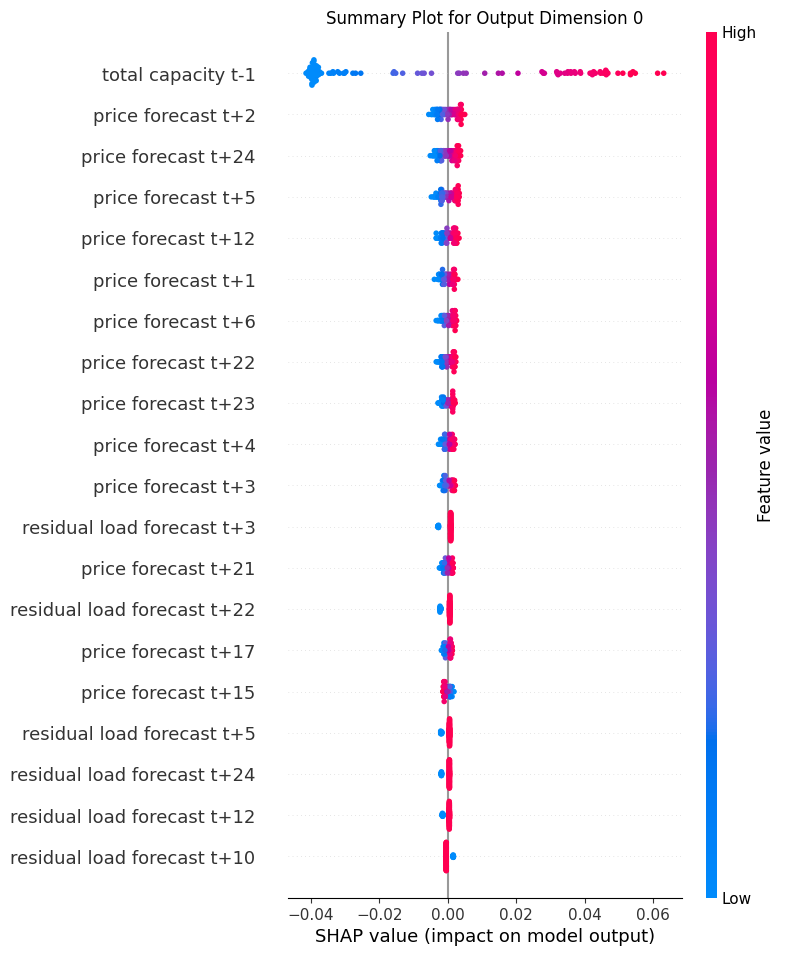

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


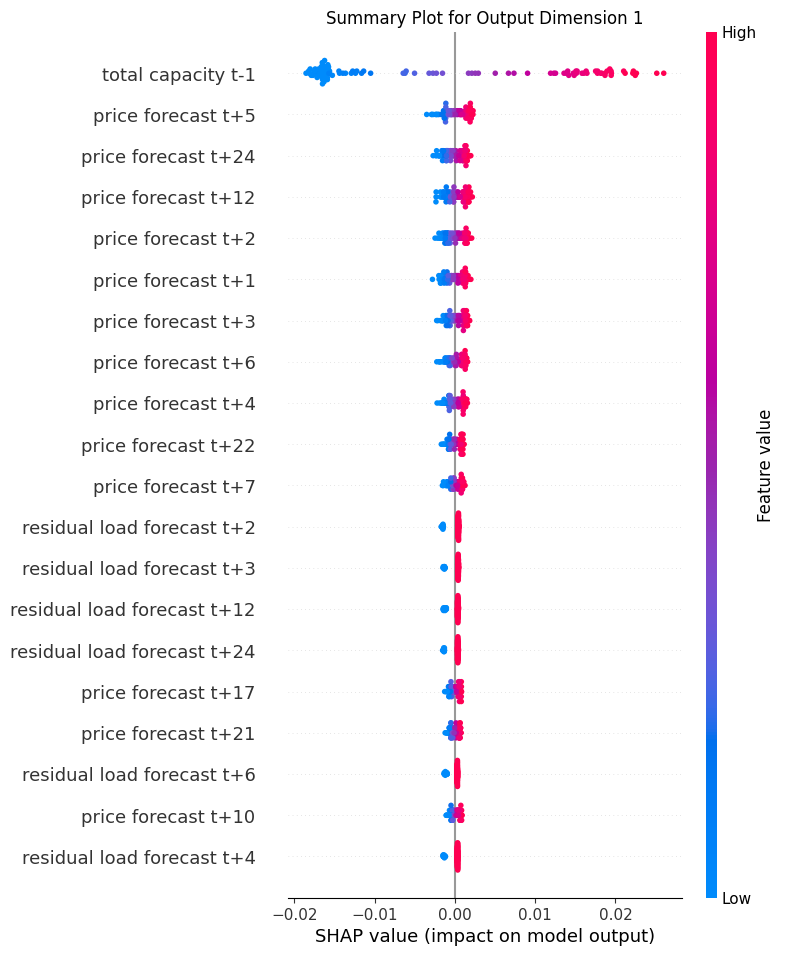

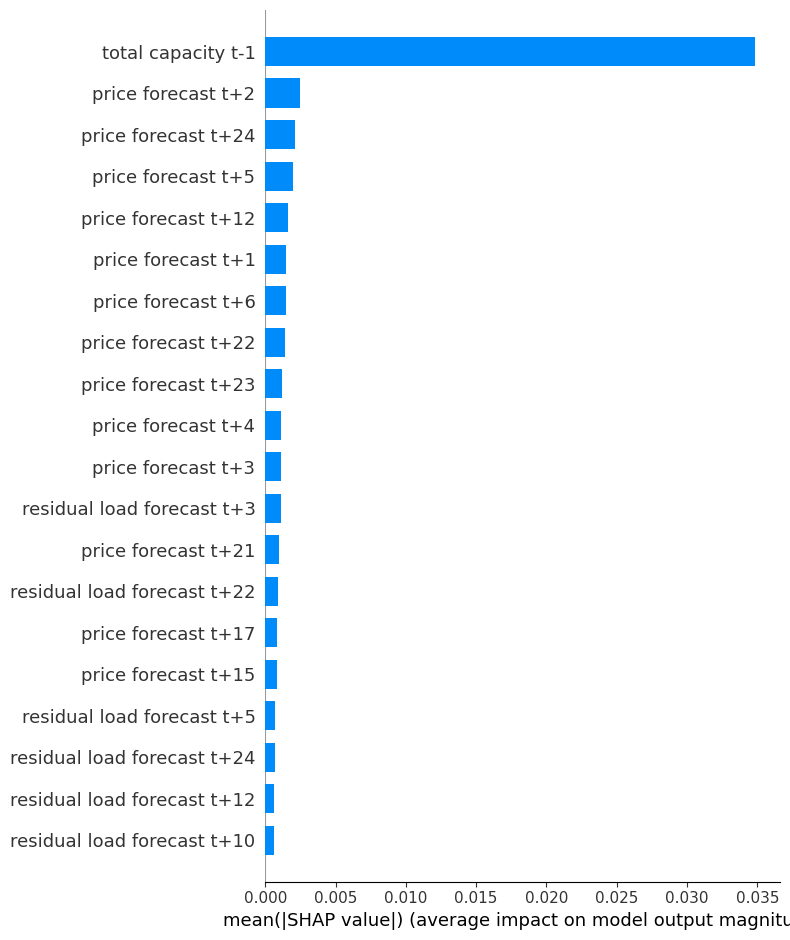

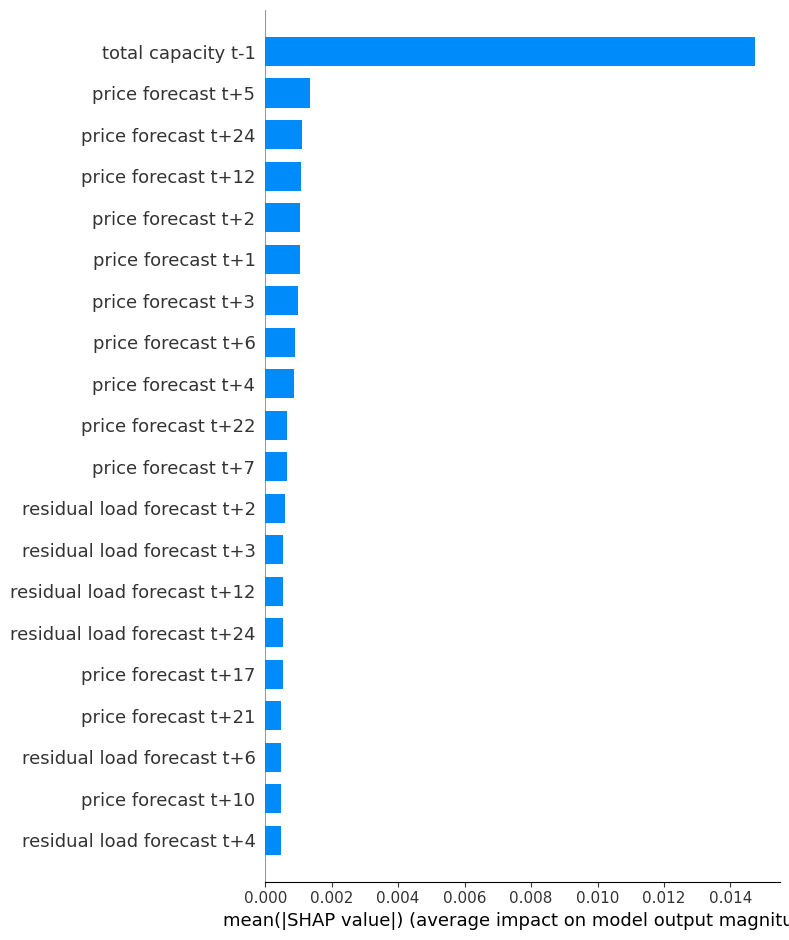

In [24]:
# Summary plot for the first output dimension
shap.summary_plot(shap_values[0], X_test, feature_names=feature_names, show=False)
plt.title("Summary Plot for Output Dimension 0")
plt.show()

# Summary plot for the second output dimension
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
plt.title("Summary Plot for Output Dimension 1")
plt.show()

shap.summary_plot(
    shap_values[0],
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    title="Summary Bar Plot for Output Dimension 0",
)

shap.summary_plot(
    shap_values[1],
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    title="Summary Bar Plot for Output Dimension 1",
)

The SHAP summary plots show the impact of each feature on the model's predictions for each output dimension (action). Features with larger absolute SHAP values have a more significant influence on the decision-making process of the RL agent.

- **Positive SHAP Value**: Indicates that the feature contributes positively to the predicted action value.
- **Negative SHAP Value**: Indicates that the feature contributes negatively to the predicted action value.

By analyzing these plots, we can identify which features are most influential and understand how changes in feature values affect the agent's actions.

## **10. Conclusion** <a name="conclusion"></a>

In this tutorial, we've demonstrated how to apply SHAP to a reinforcement learning agent to explain its decision-making process. By interpreting the SHAP values, we gain valuable insights into which features influence the agent's actions, enhancing transparency and trust in the model.

Explainability is crucial, especially when deploying RL agents in real-world applications where understanding the rationale behind decisions is essential for safety, fairness, and compliance.

---

## **11. Additional Resources** <a name="additional-resources"></a>

- **SHAP Documentation**: [https://shap.readthedocs.io/en/latest/](https://shap.readthedocs.io/en/latest/)
- **PyTorch Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
- **Reinforcement Learning Introduction**: [Richard S. Sutton and Andrew G. Barto, "Reinforcement Learning: An Introduction"](http://incompleteideas.net/book/the-book-2nd.html)
- **Interpretable Machine Learning Book**: [https://christophm.github.io/interpretable-ml-book/](https://christophm.github.io/interpretable-ml-book/)

---

**Feel free to experiment with the code and explore different explainability techniques. Happy learning!**